In [1292]:
import numpy as np 
import os 
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 
from mpl_toolkits.mplot3d import Axes3D 


def triangular_plot(chains,save='None',fig_size=25):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(fig_size,fig_size))
    if save != 'None':
        fig.set(facecolor = "white")
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1}")
    for i in range(ndim):
        for j in range(i):
            plt.subplot(ndim,ndim,ndim*i+j+1)
            counts,xbins,ybins,image = plt.hist2d(data[:,j],data[:,i],bins=100
                                      ,norm=LogNorm()
                                      , cmap = plt.cm.rainbow)
            plt.colorbar()
            plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
            linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
    if save != 'None':
        plt.savefig(save,transparent=False)
        plt.show()
    else: 
        plt.show()

def triangular_plot_slopes(chains,save='None',fig_size=25,lim=10):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(fig_size,fig_size))
    fig.set(facecolor = "white")
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            #those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope0=data[:,i]/data[:,j]
            those_slope=np.extract(np.abs(those_slope0)<lim,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j+1}/x{i+1}")
            #ax.set_ylabel(f"x{i}")
    if save != 'None':
        plt.savefig(save,transparent=False)
        plt.show()
    else: 
        plt.show()

In [1293]:
from sklearn.model_selection import train_test_split

In [1564]:
import keras
from keras import layers,models,regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau,LearningRateScheduler


In [1345]:
class ReduceLROnPlateauPercentage(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, percentage_delta=0.01):
        super(ReduceLROnPlateauPercentage, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.percentage_delta = percentage_delta
        self.best = None
        self.wait = 0
        self.lr_reduced = False

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            print(f"Warning: Metric '{self.monitor}' is not available.")
            return

        if self.best is None:
            self.best = current

        improvement = (self.best - current) / abs(self.best) if self.best != 0 else 0

        if improvement < self.percentage_delta:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr > self.min_lr:
                    new_lr = max(old_lr * self.factor, self.min_lr)
                    tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
                    print(f"\nEpoch {epoch+1}: ReduceLROnPlateau reducing learning rate to {new_lr}.")
                    self.wait = 0
        else:
            self.best = current
            self.wait = 0


In [4]:
from scipy.optimize import curve_fit 

In [5]:
import tensorflow as tf
import time

In [6]:
%matplotlib widget

In [7]:
# compute (||∇V||^2)
def grad_norm_squared(V, x ,factor=1):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared * factor

def get_grad(V, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    return gradients

In [8]:
def VHiggs_6d(x):
    x1,x2,x3,x4,x5,x6=tf.split(x, 6, axis=1)
    return (x1**2+x2**2+x3**2-1)**2 * (x4+x5+x6)

def VHiggs_10d(x):
    x1,x2,x3,x4,x5,x6,x7,x8,x9,x10=tf.split(x, 10, axis=1)
    return (x1**2+x2**2+x3**2-1)**2 * (x4+x5) * x6 * x7 * x8 * x9  

In [6]:
##########    ##########
########## 6d ##########
##########    ##########

In [31]:
# randomly initialize the points
n_points = 100000
xHiggs_6d = tf.Variable(4*np.random.rand(n_points, 6)-2, dtype=tf.float32)

historyHiggs_6d = []

In [36]:
# Oprimizer for the gradient descent

init_alpha=10**(-2)
alpha = init_alpha

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

#update_alpha = False
update_opt = True 
for step in range(600):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(VHiggs_6d, xHiggs_6d)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [xHiggs_6d])
    
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    
    if step == 1201:
        update_opt = False 
        #optimizer.learning_rate.assign(0.001)
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [xHiggs_6d]))
    
    historyHiggs_6d.append(loss)
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-10: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Reinitializing the optimizer
Step 0: ||∇V||^2 = 18.000137329101562 with learning rate 0.009999999776482582
Step 10: ||∇V||^2 = 18.154577255249023 with learning rate 0.009999999776482582
Step 20: ||∇V||^2 = 17.788881301879883 with learning rate 0.009999999776482582
Step 30: ||∇V||^2 = 16.092369079589844 with learning rate 0.009999999776482582
Step 40: ||∇V||^2 = 13.545849800109863 with learning rate 0.009999999776482582
Step 50: ||∇V||^2 = 10.62934684753418 with learning rate 0.009999999776482582
Step 60: ||∇V||^2 = 7.2760491371154785 with learning rate 0.009999999776482582
Step 70: ||∇V||^2 = 4.694639205932617 with learning rate 0.009999999776482582
Step 80: ||∇V||^2 = 3.2154667377471924 with learning rate 0.009999999776482582
Step 90: ||∇V||^2 = 3.004476308822632 with learning rate 0.009999999776482582
Step 100: ||∇V||^2 = 3.0000803470611572 with learning rate 0.009999999776482582
Step 110: ||∇V||^2 = 3.000206470489502 with learning rate 0.009999999776482582
Step 120: ||∇V||^2 = 3.000

In [37]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(VHiggs_6d,xHiggs_6d)**2,axis=1).numpy()>10**(-i))}")
          

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 0
Number of points with ||∇V||^2 > 1e-07 : 0
Number of points with ||∇V||^2 > 1e-08 : 3
Number of points with ||∇V||^2 > 1e-09 : 10
Number of points with ||∇V||^2 > 1e-10 : 15
Number of points with ||∇V||^2 > 1e-11 : 22
Number of points with ||∇V||^2 > 1e-12 : 41
Number of points with ||∇V||^2 > 1e-13 : 65
Number of points with ||∇V||^2 > 1e-14 : 115


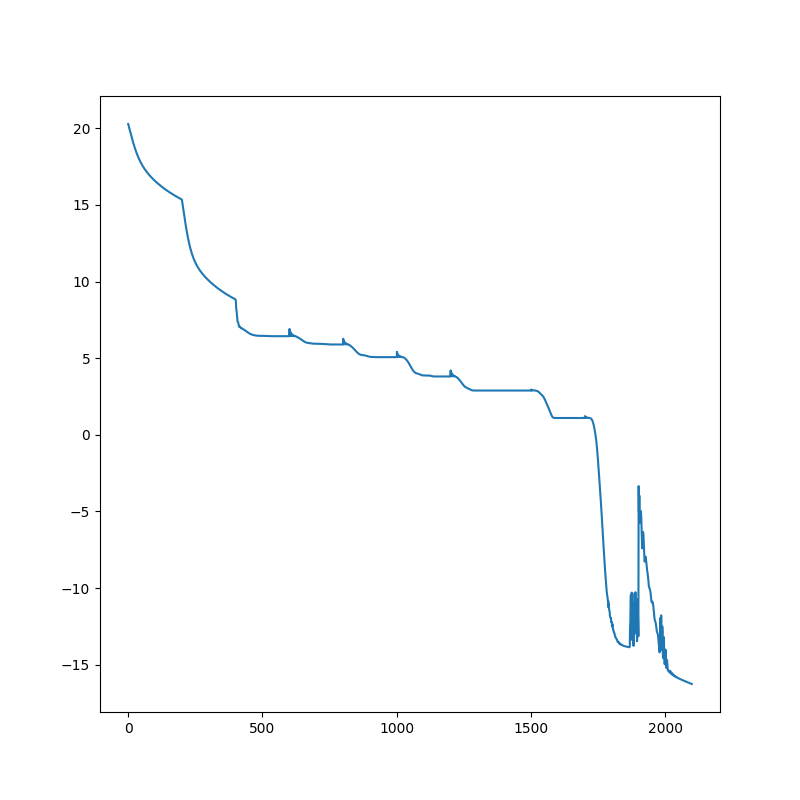

In [38]:
#all_steps = np.linspace(1,len(history),len(history))
plt.figure(figsize=(8,8))
plt.plot(np.log(historyHiggs_6d))
plt.show()

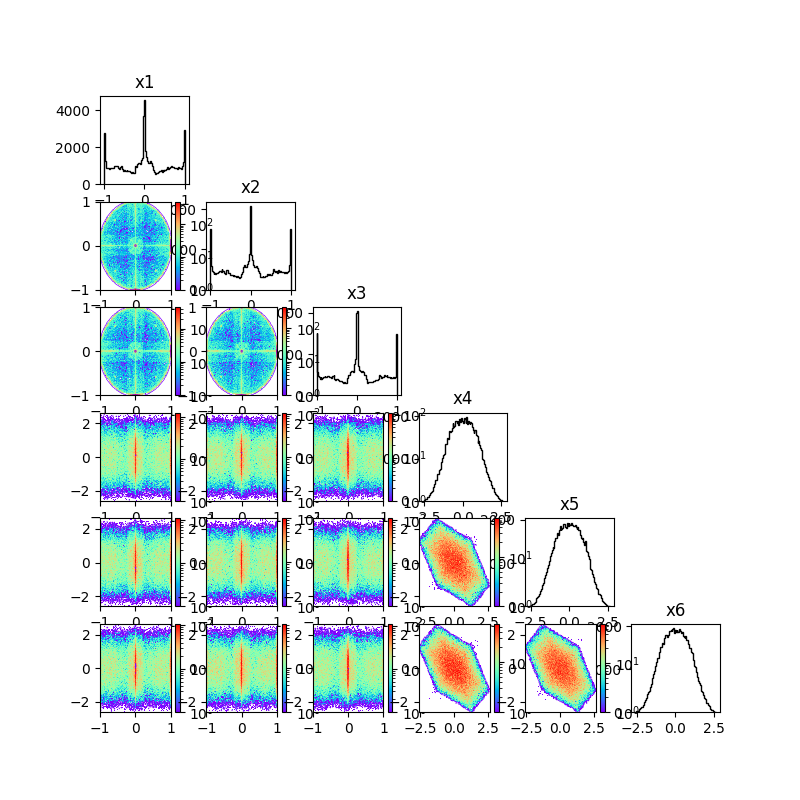

In [39]:
triangular_plot(xHiggs_6d.numpy(),fig_size=8)

In [40]:
#fig = plt.figure(figsize=(7,7))
#ax = Axes3D(fig) 
#
#ax.scatter(xHiggs_6d.numpy()[::10,0], xHiggs_6d.numpy()[::10,1], xHiggs_6d.numpy()[::10,2],color="green",s=1) 
#
#plt.show()


In [41]:
################ Auto encoder part ################
###################################################
###################################################

In [49]:
#

input_dim = 6
latent_dim = 6

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation='sigmoid')(inputs)
#encoded = layers.Dense(16, activation='sigmoid')(encoded)
#encoded = layers.Dense(16, activation='sigmoid')(encoded)
#encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
#decoded = layers.Dense(16, activation='sigmoid')(decoded)
#decoded = layers.Dense(16, activation='sigmoid')(decoded)
#decoded = layers.Dense(8, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Modèle auto-encodeur
autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [50]:
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220 (880.00 B)

 Trainable params: 220 (880.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
mask_train = np.array([np.random.rand()<0.9 for i in range(100000)])
set_train = np.array([np.extract(mask_train,xHiggs_6d.numpy()[:,i]) for i in range(6)]).T
set_test = np.array([np.extract(1-mask_train,xHiggs_6d.numpy()[:,i]) for i in range(6)]).T
print(set_train.shape)
print(set_test.shape)

(89926, 6)
(10074, 6)


In [52]:
history_autoencoder_Higgs = autoencoder.fit(set_train, set_train, epochs=100, batch_size=100, shuffle=True, validation_data=(set_test,set_test))


Epoch 1/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5963 - val_loss: 0.1554
Epoch 2/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1415 - val_loss: 0.1239
Epoch 3/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1101 - val_loss: 0.0679
Epoch 4/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0655 - val_loss: 0.0188
Epoch 5/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128 - val_loss: 0.0076
Epoch 6/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 7/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 8/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 9/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 10/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 11/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 12/100
900/900 ━━━━━━━━━━━━━━━━━━━━

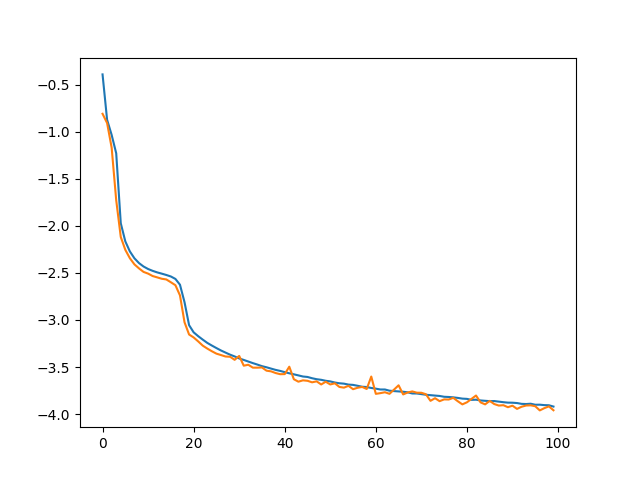

In [53]:
plt.figure()
plt.plot(np.log(history_autoencoder_Higgs.history["loss"])/np.log(10))
plt.plot(np.log(history_autoencoder_Higgs.history["val_loss"])/np.log(10))
plt.show()

In [57]:
encoder_Higgs = keras.Model(inputs, encoded)

In [58]:
encoded_points_Higgs = encoder_Higgs.predict(set_test)  
reconstructed_points = autoencoder.predict(set_test)  


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


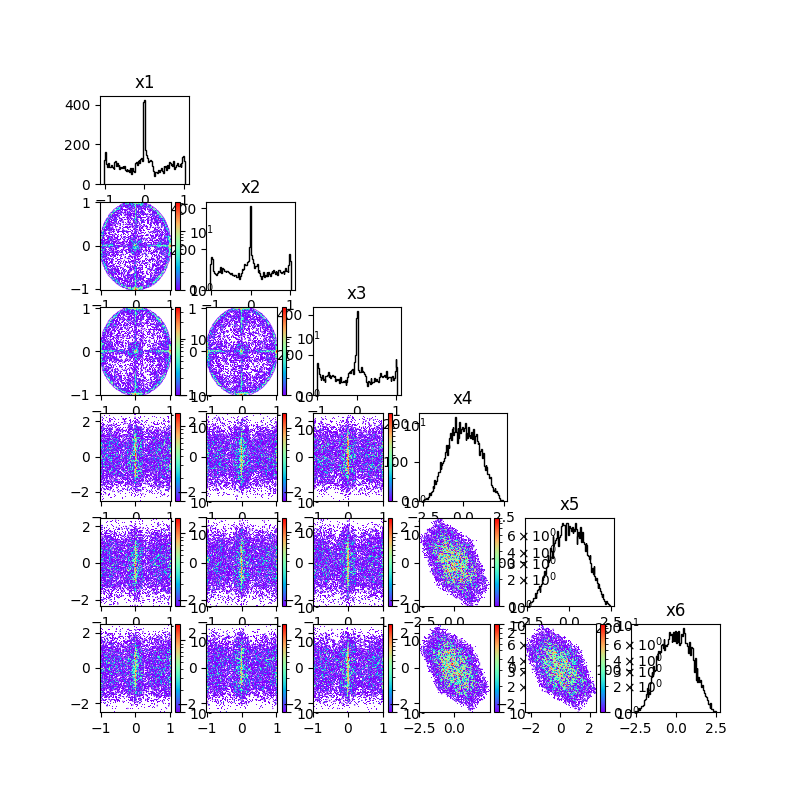

In [60]:
triangular_plot(reconstructed_points,fig_size = 8)

In [61]:
#fig = plt.figure(figsize=(7,7))
#ax = Axes3D(fig) 
#
#ax.scatter(reconstructed_points_deep[:,0],reconstructed_points_deep[:,1],reconstructed_points_deep[:,2],color="green",s=1) 
#ax.scatter(set_test[:,0],set_test[:,1],set_test[:,2],color="orange",s=1) 
#
#plt.show()


In [78]:
from joblib import Parallel, delayed
def process(i):
    return i * i
    
results = Parallel(n_jobs=2)(delayed(process)(i) for i in range(10))
print(results)  # prints [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [81]:
history_all = []

def process(i):
    this_latent_dim = i + 1
    input_dim = 6
    
    print(this_latent_dim)

    inputs = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(64, activation='sigmoid')(inputs)
    encoded = layers.Dense(64, activation='sigmoid')(encoded)
    encoded = layers.Dense(this_latent_dim)(encoded)  

    decoded = layers.Dense(64, activation='sigmoid')(encoded)
    decoded = layers.Dense(64, activation='sigmoid')(decoded)
    decoded = layers.Dense(input_dim)(decoded)  

    this_autoencoder = keras.Model(inputs, decoded)
    this_autoencoder.compile(optimizer='adam', loss='mse')
    
    history_all.append(this_autoencoder.fit(set_train, set_train, epochs=200, batch_size=100, shuffle=True, validation_data=(set_test,set_test)))

Parallel(n_jobs=4)(delayed(process)(i) for i in range(6))


2024-10-13 21:58:37.477588: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 21:58:37.477614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 21:58:37.482066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024

KeyboardInterrupt: 

In [82]:
history_all = []

for i in range(6):
    
    this_latent_dim = i + 1
    input_dim = 6
    
    print(this_latent_dim)

    inputs = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(64, activation='sigmoid')(inputs)
    encoded = layers.Dense(64, activation='sigmoid')(encoded)
    encoded = layers.Dense(this_latent_dim)(encoded)  

    decoded = layers.Dense(64, activation='sigmoid')(encoded)
    decoded = layers.Dense(64, activation='sigmoid')(decoded)
    decoded = layers.Dense(input_dim)(decoded)  

    this_autoencoder = keras.Model(inputs, decoded)
    this_autoencoder.compile(optimizer='adam', loss='mse')
    
    history_all.append(this_autoencoder.fit(set_train, set_train, epochs=200, batch_size=100, shuffle=True, validation_data=(set_test,set_test)))


1
Epoch 1/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5533 - val_loss: 0.3969
Epoch 2/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3930 - val_loss: 0.3950
Epoch 3/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3942 - val_loss: 0.3937
Epoch 4/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3934 - val_loss: 0.3943
Epoch 5/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3939 - val_loss: 0.3670
Epoch 6/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3361 - val_loss: 0.2881
Epoch 7/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2859 - val_loss: 0.2735
Epoch 8/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2679 - val_loss: 0.2609
Epoch 9/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2579 - val_loss: 0.2541
Epoch 10/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2531 - val_loss: 0.2504
Epoch 11/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2500 - val_loss: 0.2473
Epoch 12/200
900/900 ━━━━━━━━━━━━━━━━━━

Epoch 135/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2137 - val_loss: 0.2144
Epoch 136/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2126 - val_loss: 0.2149
Epoch 137/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2128 - val_loss: 0.2126
Epoch 138/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2118 - val_loss: 0.2129
Epoch 139/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2112 - val_loss: 0.2130
Epoch 140/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2122 - val_loss: 0.2139
Epoch 141/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2130 - val_loss: 0.2168
Epoch 142/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2133 - val_loss: 0.2140
Epoch 143/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2129 - val_loss: 0.2119
Epoch 144/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2115 - val_loss: 0.2125
Epoch 145/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2122 - val_loss: 0.2165
Epoch 146/200
900/900

900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1087 - val_loss: 0.1107
Epoch 69/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1086 - val_loss: 0.1099
Epoch 70/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1083 - val_loss: 0.1093
Epoch 71/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1074 - val_loss: 0.1094
Epoch 72/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1078 - val_loss: 0.1078
Epoch 73/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1069 - val_loss: 0.1073
Epoch 74/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1071 - val_loss: 0.1069
Epoch 75/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1052 - val_loss: 0.1075
Epoch 76/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1050 - val_loss: 0.1066
Epoch 77/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1037 - val_loss: 0.1061
Epoch 78/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1033 - val_loss: 0.1051
Epoch 79/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0834 - val_loss: 0.0839
Epoch 136/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0833 - val_loss: 0.0838
Epoch 137/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0829 - val_loss: 0.0840
Epoch 138/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0831 - val_loss: 0.0847
Epoch 139/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0826 - val_loss: 0.0832
Epoch 140/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0823 - val_loss: 0.0836
Epoch 141/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0821 - val_loss: 0.0834
Epoch 142/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0821 - val_loss: 0.0832
Epoch 143/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0828 - val_loss: 0.0812
Epoch 144/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0822 - val_loss: 0.0817
Epoch 145/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0813 - val_loss: 0.0814
Epoch 146/200
900/900

900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0352 - val_loss: 0.0365
Epoch 69/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0347 - val_loss: 0.0343
Epoch 70/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0345 - val_loss: 0.0347
Epoch 71/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0341 - val_loss: 0.0347
Epoch 72/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0345 - val_loss: 0.0341
Epoch 73/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0337 - val_loss: 0.0351
Epoch 74/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0339 - val_loss: 0.0346
Epoch 75/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0340 - val_loss: 0.0337
Epoch 76/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0335 - val_loss: 0.0344
Epoch 77/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0332 - val_loss: 0.0333
Epoch 78/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0330 - val_loss: 0.0333
Epoch 79/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0277 - val_loss: 0.0272
Epoch 136/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0270 - val_loss: 0.0275
Epoch 137/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0271 - val_loss: 0.0279
Epoch 138/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0271 - val_loss: 0.0268
Epoch 139/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0269 - val_loss: 0.0262
Epoch 140/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0270 - val_loss: 0.0271
Epoch 141/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0268 - val_loss: 0.0263
Epoch 142/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0268 - val_loss: 0.0268
Epoch 143/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0267 - val_loss: 0.0269
Epoch 144/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0268 - val_loss: 0.0280
Epoch 145/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0267 - val_loss: 0.0267
Epoch 146/200
900/900

900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 69/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 70/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 71/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 72/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 73/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 74/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 75/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 76/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 77/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 78/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 79/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 136/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 137/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 138/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 139/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 140/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 141/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 142/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 143/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 144/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 145/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 146/200
900/900

900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 69/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 70/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 71/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 72/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 73/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 74/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 75/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 76/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 77/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 78/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 79/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 136/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 137/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 138/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 139/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 140/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 141/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 142/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 143/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 144/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 145/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 146/200
900/900

Epoch 67/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.7982e-05 - val_loss: 4.1090e-05
Epoch 68/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.0817e-05 - val_loss: 7.8505e-05
Epoch 69/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.9442e-05 - val_loss: 9.1457e-05
Epoch 70/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1957e-05 - val_loss: 5.0321e-05
Epoch 71/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.6125e-05 - val_loss: 3.3795e-05
Epoch 72/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2198e-05 - val_loss: 6.4437e-05
Epoch 73/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1655e-05 - val_loss: 7.9461e-05
Epoch 74/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1750e-05 - val_loss: 4.3665e-05
Epoch 75/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.9126e-05 - val_loss: 6.1026e-05
Epoch 76/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.9512e-05 - val_loss: 7.6685e-05
Epoch 77/200
900/900 ━━━━━━━━━━━━━━━━━━━

900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.9790e-05 - val_loss: 6.3589e-05
Epoch 192/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1921e-05 - val_loss: 1.5832e-05
Epoch 193/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2632e-05 - val_loss: 3.2927e-05
Epoch 194/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.3469e-05 - val_loss: 2.8629e-05
Epoch 195/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.4284e-05 - val_loss: 1.7642e-05
Epoch 196/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.6075e-05 - val_loss: 5.1101e-05
Epoch 197/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.8730e-05 - val_loss: 1.7203e-05
Epoch 198/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.5727e-05 - val_loss: 2.0811e-05
Epoch 199/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6957e-05 - val_loss: 1.3703e-05
Epoch 200/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7610e-05 - val_loss: 2.1349e-05


In [83]:
history_min = []
for this_history in history_all: 
    this_min = np.min(this_history.history['val_loss'])
    history_min.append(this_min)

/var/folders/7f/2871v4nx3pn_dph55xj6sxq40000gn/T/ipykernel_7665/610947544.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


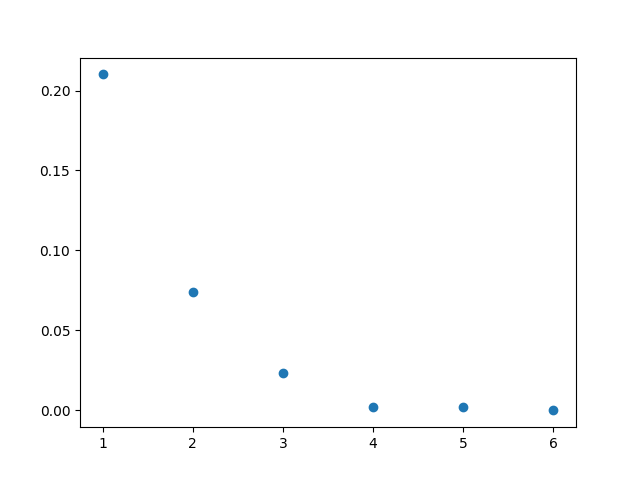

In [86]:
plt.figure()
plt.scatter(np.linspace(1,6,6),history_min)
plt.show()

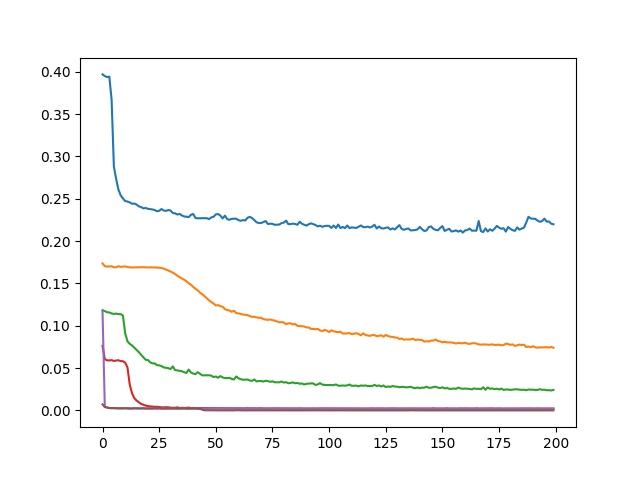

In [87]:
plt.figure()
for this_history in history_all:
    plt.plot(this_history.history['val_loss'])
plt.show()    

In [ ]:
##########     ##########
########## 10d ##########
##########     ##########

In [171]:
# randomly initialize the points
n_points = 100000
xHiggs_10d = tf.Variable(2*np.random.rand(n_points, 10)-1, dtype=tf.float32)

historyHiggs_10d = []

In [173]:
# Oprimizer for the gradient descent

init_alpha=10**(-2)
alpha = init_alpha

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

#update_alpha = False
update_opt = True 
for step in range(1400):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(VHiggs_10d, xHiggs_10d)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [xHiggs_10d])
    
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    
    if step == 1501:
        update_opt = False 
        #optimizer.learning_rate.assign(0.001)
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [xHiggs_10d]))
    
    historyHiggs_10d.append(loss)
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-10: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Reinitializing the optimizer
Step 0: ||∇V||^2 = 0.04170980304479599 with learning rate 0.009999999776482582
Step 10: ||∇V||^2 = 0.024053478613495827 with learning rate 0.009999999776482582
Step 20: ||∇V||^2 = 0.004544761031866074 with learning rate 0.009999999776482582
Step 30: ||∇V||^2 = 0.0008592294179834425 with learning rate 0.009999999776482582
Step 40: ||∇V||^2 = 0.000349969050148502 with learning rate 0.009999999776482582
Step 50: ||∇V||^2 = 0.00011958558752667159 with learning rate 0.009999999776482582
Step 60: ||∇V||^2 = 5.228185546002351e-05 with learning rate 0.009999999776482582
Step 70: ||∇V||^2 = 2.4384204152738675e-05 with learning rate 0.009999999776482582
Step 80: ||∇V||^2 = 1.3051840141997673e-05 with learning rate 0.009999999776482582
Step 90: ||∇V||^2 = 8.368111593881622e-06 with learning rate 0.009999999776482582
Step 100: ||∇V||^2 = 6.0273250710451975e-06 with learning rate 0.009999999776482582
Step 110: ||∇V||^2 = 4.685076419264078e-06 with learning rate 0.009999

KeyboardInterrupt: 

In [174]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(VHiggs_10d,xHiggs_10d)**2,axis=1).numpy()>10**(-i))}")
          

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 0
Number of points with ||∇V||^2 > 1e-07 : 0
Number of points with ||∇V||^2 > 1e-08 : 0
Number of points with ||∇V||^2 > 1e-09 : 21
Number of points with ||∇V||^2 > 1e-10 : 544
Number of points with ||∇V||^2 > 1e-11 : 1872
Number of points with ||∇V||^2 > 1e-12 : 5195
Number of points with ||∇V||^2 > 1e-13 : 14334
Number of points with ||∇V||^2 > 1e-14 : 25014


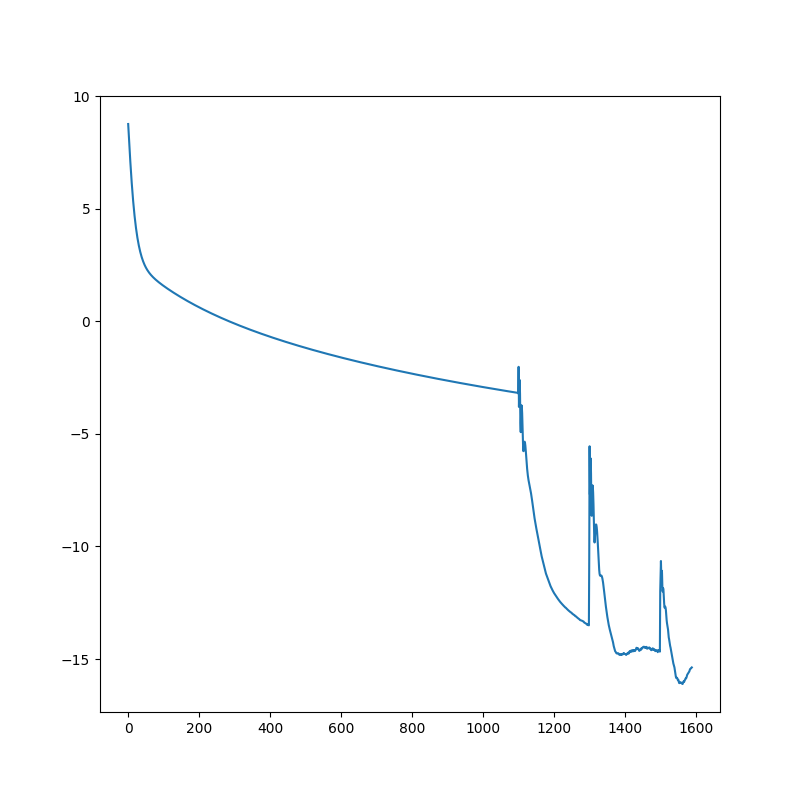

In [175]:
#all_steps = np.linspace(1,len(history),len(history))
plt.figure(figsize=(8,8))
plt.plot(np.log(historyHiggs_10d))
plt.show()

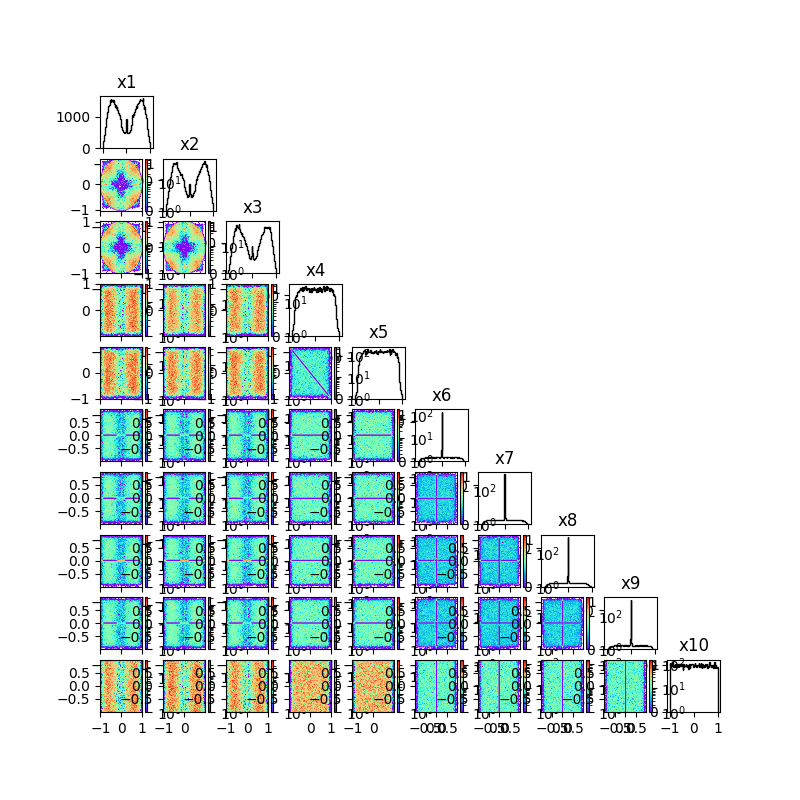

In [176]:
triangular_plot(xHiggs_10d.numpy(),fig_size=8)

In [177]:
mask_train = np.array([np.random.rand()<0.9 for i in range(100000)])
set_train = np.array([np.extract(mask_train,xHiggs_10d.numpy()[:,i]) for i in range(10)]).T
set_test = np.array([np.extract(1-mask_train,xHiggs_10d.numpy()[:,i]) for i in range(10)]).T
print(set_train.shape)
print(set_test.shape)

(90010, 10)
(9990, 10)


In [178]:
history_all_10d = []

for i in range(10):
    
    this_latent_dim = i + 1
    input_dim = 10
    
    print(this_latent_dim)

    inputs = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='sigmoid')(inputs)
    encoded = layers.Dense(128, activation='sigmoid')(encoded)
    encoded = layers.Dense(this_latent_dim)(encoded)  

    decoded = layers.Dense(128, activation='sigmoid')(encoded)
    decoded = layers.Dense(128, activation='sigmoid')(decoded)
    decoded = layers.Dense(input_dim)(decoded)  

    this_autoencoder = keras.Model(inputs, decoded)
    this_autoencoder.compile(optimizer='adam', loss='mse')
    
    history_all_10d.append(this_autoencoder.fit(set_train, set_train, epochs=200, batch_size=100, shuffle=True, validation_data=(set_test,set_test)))


1
Epoch 1/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2862 - val_loss: 0.2374
Epoch 2/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2365 - val_loss: 0.2367
Epoch 3/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2365 - val_loss: 0.2367
Epoch 4/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2358 - val_loss: 0.2359
Epoch 5/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2337 - val_loss: 0.2239
Epoch 6/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2223 - val_loss: 0.2166
Epoch 7/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2154 - val_loss: 0.2118
Epoch 8/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2115 - val_loss: 0.2097
Epoch 9/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2096 - val_loss: 0.2086
Epoch 10/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2081 - val_loss: 0.2059
Epoch 11/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2050 - val_loss: 0.2054
Epoch 12/200
901/901 ━━━━━━━━━━━━━━━━━━

Epoch 135/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1670 - val_loss: 0.1665
Epoch 136/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1668 - val_loss: 0.1668
Epoch 137/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1661 - val_loss: 0.1670
Epoch 138/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1670 - val_loss: 0.1666
Epoch 139/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1664 - val_loss: 0.1663
Epoch 140/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1660 - val_loss: 0.1664
Epoch 141/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1663 - val_loss: 0.1655
Epoch 142/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1659 - val_loss: 0.1672
Epoch 143/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1660 - val_loss: 0.1661
Epoch 144/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1662 - val_loss: 0.1655
Epoch 145/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1657 - val_loss: 0.1653
Epoch 146/200
901/901

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1220 - val_loss: 0.1220
Epoch 69/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1218 - val_loss: 0.1214
Epoch 70/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1212 - val_loss: 0.1209
Epoch 71/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1203 - val_loss: 0.1203
Epoch 72/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1202 - val_loss: 0.1195
Epoch 73/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1194 - val_loss: 0.1189
Epoch 74/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1190 - val_loss: 0.1189
Epoch 75/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1183 - val_loss: 0.1180
Epoch 76/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1179 - val_loss: 0.1177
Epoch 77/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1176 - val_loss: 0.1172
Epoch 78/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1174 - val_loss: 0.1171
Epoch 79/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0974 - val_loss: 0.0983
Epoch 136/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0969 - val_loss: 0.0977
Epoch 137/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0970 - val_loss: 0.0981
Epoch 138/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0968 - val_loss: 0.0977
Epoch 139/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0965 - val_loss: 0.0976
Epoch 140/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0964 - val_loss: 0.0978
Epoch 141/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0964 - val_loss: 0.0982
Epoch 142/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0961 - val_loss: 0.0968
Epoch 143/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0960 - val_loss: 0.0966
Epoch 144/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0954 - val_loss: 0.0968
Epoch 145/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0957 - val_loss: 0.0964
Epoch 146/200
901/901

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0882 - val_loss: 0.0889
Epoch 69/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0883 - val_loss: 0.0883
Epoch 70/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0879 - val_loss: 0.0884
Epoch 71/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0882 - val_loss: 0.0886
Epoch 72/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0876 - val_loss: 0.0878
Epoch 73/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0869 - val_loss: 0.0877
Epoch 74/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0873 - val_loss: 0.0867
Epoch 75/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0870 - val_loss: 0.0870
Epoch 76/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0867 - val_loss: 0.0872
Epoch 77/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0861 - val_loss: 0.0868
Epoch 78/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0861 - val_loss: 0.0865
Epoch 79/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 

Epoch 135/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0615 - val_loss: 0.0625
Epoch 136/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0613 - val_loss: 0.0621
Epoch 137/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0613 - val_loss: 0.0624
Epoch 138/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0608 - val_loss: 0.0621
Epoch 139/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0604 - val_loss: 0.0621
Epoch 140/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0606 - val_loss: 0.0619
Epoch 141/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0604 - val_loss: 0.0610
Epoch 142/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0600 - val_loss: 0.0610
Epoch 143/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0597 - val_loss: 0.0613
Epoch 144/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0593 - val_loss: 0.0607
Epoch 145/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0594 - val_loss: 0.0602
Epoch 146/200
901/901

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0682 - val_loss: 0.0682
Epoch 69/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0673 - val_loss: 0.0687
Epoch 70/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0677 - val_loss: 0.0680
Epoch 71/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0667 - val_loss: 0.0686
Epoch 72/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0667 - val_loss: 0.0673
Epoch 73/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0666 - val_loss: 0.0691
Epoch 74/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0673 - val_loss: 0.0687
Epoch 75/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0675 - val_loss: 0.0691
Epoch 76/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0672 - val_loss: 0.0720
Epoch 77/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0696 - val_loss: 0.0695
Epoch 78/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0671 - val_loss: 0.0667
Epoch 79/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0484 - val_loss: 0.0493
Epoch 136/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0483 - val_loss: 0.0489
Epoch 137/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0481 - val_loss: 0.0486
Epoch 138/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0478 - val_loss: 0.0493
Epoch 139/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0478 - val_loss: 0.0478
Epoch 140/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0473 - val_loss: 0.0481
Epoch 141/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0473 - val_loss: 0.0490
Epoch 142/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0474 - val_loss: 0.0475
Epoch 143/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0468 - val_loss: 0.0494
Epoch 144/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0473 - val_loss: 0.0480
Epoch 145/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0469 - val_loss: 0.0468
Epoch 146/200
901/901

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0314 - val_loss: 0.0314
Epoch 69/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0313 - val_loss: 0.0319
Epoch 70/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0311 - val_loss: 0.0319
Epoch 71/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0308 - val_loss: 0.0311
Epoch 72/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0306 - val_loss: 0.0312
Epoch 73/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0305 - val_loss: 0.0308
Epoch 74/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0303 - val_loss: 0.0306
Epoch 75/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0299 - val_loss: 0.0313
Epoch 76/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0302 - val_loss: 0.0305
Epoch 77/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0298 - val_loss: 0.0302
Epoch 78/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0297 - val_loss: 0.0301
Epoch 79/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0237 - val_loss: 0.0247
Epoch 136/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0233 - val_loss: 0.0244
Epoch 137/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0234 - val_loss: 0.0248
Epoch 138/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0231 - val_loss: 0.0246
Epoch 139/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0231 - val_loss: 0.0238
Epoch 140/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0230 - val_loss: 0.0240
Epoch 141/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0229 - val_loss: 0.0246
Epoch 142/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0227 - val_loss: 0.0238
Epoch 143/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0226 - val_loss: 0.0240
Epoch 144/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0228 - val_loss: 0.0239
Epoch 145/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0225 - val_loss: 0.0241
Epoch 146/200
901/901

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0204 - val_loss: 0.0211
Epoch 69/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0203 - val_loss: 0.0209
Epoch 70/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0205 - val_loss: 0.0212
Epoch 71/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0203 - val_loss: 0.0215
Epoch 72/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0200 - val_loss: 0.0204
Epoch 73/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0198 - val_loss: 0.0206
Epoch 74/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0198 - val_loss: 0.0204
Epoch 75/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0196 - val_loss: 0.0204
Epoch 76/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0196 - val_loss: 0.0208
Epoch 77/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0194 - val_loss: 0.0200
Epoch 78/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0193 - val_loss: 0.0202
Epoch 79/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0157 - val_loss: 0.0165
Epoch 136/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0157 - val_loss: 0.0164
Epoch 137/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0156 - val_loss: 0.0163
Epoch 138/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0156 - val_loss: 0.0164
Epoch 139/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0153 - val_loss: 0.0167
Epoch 140/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0153 - val_loss: 0.0164
Epoch 141/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0154 - val_loss: 0.0163
Epoch 142/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0154 - val_loss: 0.0159
Epoch 143/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0153 - val_loss: 0.0162
Epoch 144/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0154 - val_loss: 0.0163
Epoch 145/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0152 - val_loss: 0.0160
Epoch 146/200
901/901

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0134 - val_loss: 0.0140
Epoch 69/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0135 - val_loss: 0.0140
Epoch 70/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0133 - val_loss: 0.0148
Epoch 71/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0133 - val_loss: 0.0137
Epoch 72/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0132 - val_loss: 0.0134
Epoch 73/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0131 - val_loss: 0.0134
Epoch 74/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0130 - val_loss: 0.0135
Epoch 75/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0131 - val_loss: 0.0136
Epoch 76/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0132 - val_loss: 0.0135
Epoch 77/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0130 - val_loss: 0.0129
Epoch 78/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 79/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0103 - val_loss: 0.0108
Epoch 136/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 137/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 138/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 139/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0101 - val_loss: 0.0106
Epoch 140/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 141/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0099 - val_loss: 0.0107
Epoch 142/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0100 - val_loss: 0.0106
Epoch 143/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 144/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 145/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0099 - val_loss: 0.0103
Epoch 146/200
901/901

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 69/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 70/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 71/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 72/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0065 - val_loss: 0.0068
Epoch 73/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 74/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 75/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 76/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 77/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 78/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 79/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 136/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 137/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 138/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 139/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 140/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 141/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 142/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 143/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 144/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 145/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 146/200
901/901

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.6187e-04 - val_loss: 9.2934e-04
Epoch 68/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.3078e-04 - val_loss: 8.8493e-04
Epoch 69/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.6422e-04 - val_loss: 9.1756e-04
Epoch 70/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.4032e-04 - val_loss: 8.5057e-04
Epoch 71/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.3140e-04 - val_loss: 8.8064e-04
Epoch 72/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2395e-04 - val_loss: 8.6085e-04
Epoch 73/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.4258e-04 - val_loss: 9.8676e-04
Epoch 74/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2456e-04 - val_loss: 8.5387e-04
Epoch 75/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.1510e-04 - val_loss: 8.7704e-04
Epoch 76/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.0621e-04 - val_loss: 8.7638e-04
Epoch 77/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 130/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.6698e-04 - val_loss: 7.9564e-04
Epoch 131/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5510e-04 - val_loss: 7.8270e-04
Epoch 132/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.4493e-04 - val_loss: 8.3128e-04
Epoch 133/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.6792e-04 - val_loss: 7.9392e-04
Epoch 134/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.6893e-04 - val_loss: 8.0002e-04
Epoch 135/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5087e-04 - val_loss: 8.0470e-04
Epoch 136/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5649e-04 - val_loss: 7.9489e-04
Epoch 137/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5387e-04 - val_loss: 7.7846e-04
Epoch 138/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5766e-04 - val_loss: 7.8734e-04
Epoch 139/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.4745e-04 - val_loss: 8.0466e-04
Epoch 140/200
901/901 ━━━━━━━━

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.1276e-05 - val_loss: 1.2727e-04
Epoch 56/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.4628e-05 - val_loss: 7.3935e-05
Epoch 57/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.6954e-05 - val_loss: 9.0509e-05
Epoch 58/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.6361e-05 - val_loss: 1.4577e-04
Epoch 59/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.6970e-05 - val_loss: 9.3431e-05
Epoch 60/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5703e-05 - val_loss: 9.4477e-05
Epoch 61/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.6854e-05 - val_loss: 1.1811e-04
Epoch 62/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.0124e-05 - val_loss: 1.1906e-04
Epoch 63/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.1180e-05 - val_loss: 7.6781e-05
Epoch 64/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.6807e-05 - val_loss: 9.9157e-05
Epoch 65/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 118/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2738e-05 - val_loss: 4.4609e-05
Epoch 119/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9428e-05 - val_loss: 2.4839e-05
Epoch 120/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7862e-05 - val_loss: 6.5331e-05
Epoch 121/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0474e-05 - val_loss: 4.2178e-05
Epoch 122/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9388e-05 - val_loss: 4.8055e-05
Epoch 123/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7743e-05 - val_loss: 2.8522e-05
Epoch 124/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0379e-05 - val_loss: 3.2797e-05
Epoch 125/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9568e-05 - val_loss: 7.4129e-05
Epoch 126/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0766e-05 - val_loss: 3.6522e-05
Epoch 127/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9080e-05 - val_loss: 4.0501e-05
Epoch 128/200
901/901 ━━━━━━━━

In [179]:
history_min = []
for this_history in history_all_10d: 
    this_min = np.min(this_history.history['val_loss'])
    history_min.append(this_min)

In [180]:
(history_min[-1]-history_min[-2])

-0.0007359417277257307

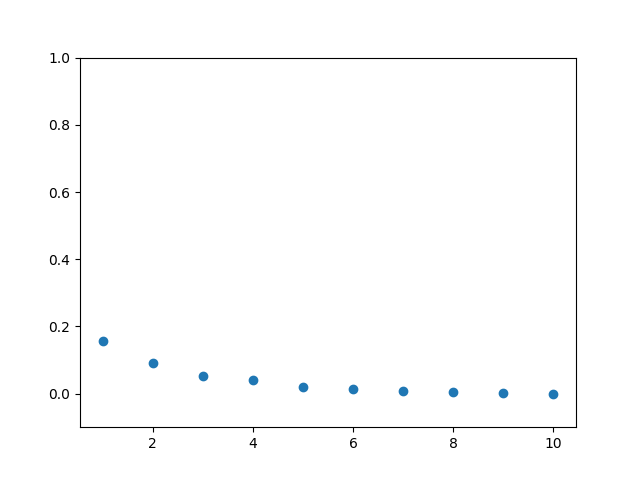

In [181]:
plt.figure()
#plt.plot(-0.2409968376159668*np.linspace(1,10,10)+1.23,c='orange')
#plt.plot(-0.0129408444481669*np.linspace(1,11,11)+0.14,c='orange')
plt.scatter(np.linspace(1,10,10),history_min)
plt.ylim((-0.1,1))
plt.show()

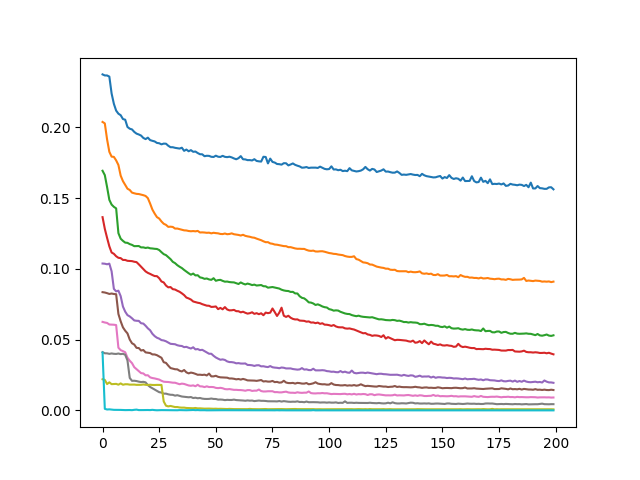

In [182]:
plt.figure()
for this_history in history_all_10d:
    plt.plot(this_history.history['val_loss'])
plt.show()    

In [183]:
##########       ##########
########## 5d 1  ##########
##########       ##########

In [212]:
def V_5d_1(x):
    x1,x2,x3,x4,x5 = tf.split(x,5,axis=1)
    return 29 * (x1 ** 2) + 41.66666666666667 * (x1 ** 3) + 81 * (x1 ** 4) -36 * x1 * x2 + 540 * (x1 ** 3) * x2 + 20 * (x2 ** 2) + 1350 * (x1 ** 2) * (x2 ** 2) + 1500 * x1 * (x2 ** 3) + 625 * (x2 ** 4) + 32 * x1 * x3 -50 * (x1 ** 2) * x3 + 324 * (x1 ** 3) * x3 + 1620 * (x1 ** 2) * x2 * x3 + 2700 * x1 * (x2 ** 2) * x3 + 1500 * (x2 ** 3) * x3 + 20 * (x3 ** 2) + 20 * x1 * (x3 ** 2) + 486 * (x1 ** 2) * (x3 ** 2) + 1620 * x1 * x2 * (x3 ** 2) + 1350 * (x2 ** 2) * (x3 ** 2) -2.666666666666667 * (x3 ** 3) + 324 * x1 * (x3 ** 3) + 540 * x2 * (x3 ** 3) + 81 * (x3 ** 4) -4 * x1 * x4 -25 * (x1 ** 2) * x4 -540 * (x1 ** 3) * x4 + 40 * x2 * x4 -2700 * (x1 ** 2) * x2 * x4 -4500 * x1 * (x2 ** 2) * x4 -2500 * (x2 ** 3) * x4 + 40 * x3 * x4 + 20 * x1 * x3 * x4 -1620 * (x1 ** 2) * x3 * x4 -5400 * x1 * x2 * x3 * x4 -4500 * (x2 ** 2) * x3 * x4 -4 * (x3 ** 2) * x4 -1620 * x1 * (x3 ** 2) * x4 -2700 * x2 * (x3 ** 2) * x4 -540 * (x3 ** 3) * x4 + 40 * (x4 ** 2) + 5 * x1 * (x4 ** 2) + 1350 * (x1 ** 2) * (x4 ** 2) + 4500 * x1 * x2 * (x4 ** 2) + 3750 * (x2 ** 2) * (x4 ** 2) -2 * x3 * (x4 ** 2) + 2700 * x1 * x3 * (x4 ** 2) + 4500 * x2 * x3 * (x4 ** 2) + 1350 * (x3 ** 2) * (x4 ** 2) -0.3333333333333333 * (x4 ** 3) -1500 * x1 * (x4 ** 3) -2500 * x2 * (x4 ** 3) -1500 * x3 * (x4 ** 3) + 625 * (x4 ** 4) + 8 * x1 * x5 + 200 * (x1 ** 2) * x5 + 216 * (x1 ** 3) * x5 -16 * x2 * x5 + 1080 * (x1 ** 2) * x2 * x5 + 1800 * x1 * (x2 ** 2) * x5 + 1000 * (x2 ** 3) * x5 -8 * x3 * x5 -160 * x1 * x3 * x5 + 648 * (x1 ** 2) * x3 * x5 + 2160 * x1 * x2 * x3 * x5 + 1800 * (x2 ** 2) * x3 * x5 + 32 * (x3 ** 2) * x5 + 648 * x1 * (x3 ** 2) * x5 + 1080 * x2 * (x3 ** 2) * x5 + 216 * (x3 ** 3) * x5 -24 * x4 * x5 -80 * x1 * x4 * x5 -1080 * (x1 ** 2) * x4 * x5 -3600 * x1 * x2 * x4 * x5 -3000 * (x2 ** 2) * x4 * x5 + 32 * x3 * x4 * x5 -2160 * x1 * x3 * x4 * x5 -3600 * x2 * x3 * x4 * x5 -1080 * (x3 ** 2) * x4 * x5 + 8 * (x4 ** 2) * x5 + 1800 * x1 * (x4 ** 2) * x5 + 3000 * x2 * (x4 ** 2) * x5 + 1800 * x3 * (x4 ** 2) * x5 -1000 * (x4 ** 3) * x5 + 4 * (x5 ** 2) + 320 * x1 * (x5 ** 2) + 216 * (x1 ** 2) * (x5 ** 2) + 720 * x1 * x2 * (x5 ** 2) + 600 * (x2 ** 2) * (x5 ** 2) -128 * x3 * (x5 ** 2) + 432 * x1 * x3 * (x5 ** 2) + 720 * x2 * x3 * (x5 ** 2) + 216 * (x3 ** 2) * (x5 ** 2) -64 * x4 * (x5 ** 2) -720 * x1 * x4 * (x5 ** 2) -1200 * x2 * x4 * (x5 ** 2) -720 * x3 * x4 * (x5 ** 2) + 600 * (x4 ** 2) * (x5 ** 2) + 170.6666666666667 * (x5 ** 3) + 96 * x1 * (x5 ** 3) + 160 * x2 * (x5 ** 3) + 96 * x3 * (x5 ** 3) -160 * x4 * (x5 ** 3) + 16 * (x5 ** 4)
    

In [213]:
# randomly initialize the points
n_points = 100000
xHiggs_5d_1 = tf.Variable(4*np.random.rand(n_points, 5)-2, dtype=tf.float32)

historyHiggs_5d_1 = []

In [220]:
# Oprimizer for the gradient descent

init_alpha=10**(-4)
alpha = init_alpha

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

#update_alpha = False
update_opt = False 
for step in range(1600):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V_5d_1, xHiggs_5d_1)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [xHiggs_5d_1])
    
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    
    if step == 1401:
        update_opt = False 
        #optimizer.learning_rate.assign(0.001)
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [xHiggs_5d_1]))
    
    historyHiggs_5d_1.append(loss)
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-10: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Step 0: ||∇V||^2 = 0.27628928422927856 with learning rate 9.999999747378752e-05
Step 10: ||∇V||^2 = 10.805624961853027 with learning rate 9.999999747378752e-05
Step 20: ||∇V||^2 = 2.5189208984375 with learning rate 9.999999747378752e-05
Step 30: ||∇V||^2 = 0.4089205861091614 with learning rate 9.999999747378752e-05
Step 40: ||∇V||^2 = 0.4265826940536499 with learning rate 9.999999747378752e-05
Step 50: ||∇V||^2 = 0.3378164768218994 with learning rate 9.999999747378752e-05
Step 60: ||∇V||^2 = 0.26900598406791687 with learning rate 9.999999747378752e-05
Step 70: ||∇V||^2 = 0.23749952018260956 with learning rate 9.999999747378752e-05
Step 80: ||∇V||^2 = 0.2276814728975296 with learning rate 9.999999747378752e-05
Step 90: ||∇V||^2 = 0.2260069102048874 with learning rate 9.999999747378752e-05
Step 100: ||∇V||^2 = 0.22392848134040833 with learning rate 9.999999747378752e-05


KeyboardInterrupt: 

In [221]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(V_5d_1,xHiggs_5d_1)**2,axis=1).numpy()>10**(-i))}")
          

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 27
Number of points with ||∇V||^2 > 1e-05 : 2763
Number of points with ||∇V||^2 > 1e-06 : 51057
Number of points with ||∇V||^2 > 1e-07 : 92519
Number of points with ||∇V||^2 > 1e-08 : 98182
Number of points with ||∇V||^2 > 1e-09 : 99866
Number of points with ||∇V||^2 > 1e-10 : 99995
Number of points with ||∇V||^2 > 1e-11 : 99998
Number of points with ||∇V||^2 > 1e-12 : 99998
Number of points with ||∇V||^2 > 1e-13 : 99998
Number of points with ||∇V||^2 > 1e-14 : 99998


In [252]:
mask_train = np.array([np.random.rand()<0.9 for i in range(100000)])
set_train_5d = np.array([np.extract(mask_train,xHiggs_5d_1.numpy()[:,i]) for i in range(5)]).T
set_test_5d = np.array([np.extract(1-mask_train,xHiggs_5d_1.numpy()[:,i]) for i in range(5)]).T
print(set_train_5d.shape)
print(set_test_5d.shape)

(90054, 10)
(9946, 10)


In [225]:
history_all_5d_1 = []

for i in range(5):
    
    this_latent_dim = i + 1
    input_dim = 5
    
    print(this_latent_dim)

    inputs = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='sigmoid')(inputs)
    encoded = layers.Dense(128, activation='sigmoid')(encoded)
    encoded = layers.Dense(this_latent_dim)(encoded)  

    decoded = layers.Dense(128, activation='sigmoid')(encoded)
    decoded = layers.Dense(128, activation='sigmoid')(decoded)
    decoded = layers.Dense(input_dim)(decoded)  

    this_autoencoder = keras.Model(inputs, decoded)
    this_autoencoder.compile(optimizer='adam', loss='mse')
    
    history_all_5d_1.append(this_autoencoder.fit(set_train_5d, set_train_5d, epochs=100, batch_size=100, shuffle=True, validation_data=(set_test_5d,set_test_5d)))


1
Epoch 1/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1474 - val_loss: 4.7412e-04
Epoch 2/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2208e-04 - val_loss: 1.1419e-04
Epoch 3/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.1346e-05 - val_loss: 4.9573e-05
Epoch 4/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.1970e-05 - val_loss: 2.9993e-05
Epoch 5/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2343e-05 - val_loss: 1.2200e-04
Epoch 6/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.3760e-05 - val_loss: 1.8720e-05
Epoch 7/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.7011e-05 - val_loss: 6.8911e-05
Epoch 8/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.1152e-05 - val_loss: 1.8011e-04
Epoch 9/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.9989e-05 - val_loss: 4.5366e-05
Epoch 10/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.8006e-05 - val_loss: 2.4524e-05
Epoch 11/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/st

899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3330e-05 - val_loss: 1.0156e-05
Epoch 28/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0215e-05 - val_loss: 6.3089e-05
Epoch 29/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6195e-05 - val_loss: 1.4923e-05
Epoch 30/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0434e-05 - val_loss: 3.6875e-06
Epoch 31/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6954e-05 - val_loss: 6.5487e-06
Epoch 32/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9143e-05 - val_loss: 5.0530e-06
Epoch 33/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3463e-05 - val_loss: 2.7901e-05
Epoch 34/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8154e-05 - val_loss: 5.2288e-06
Epoch 35/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8230e-05 - val_loss: 1.8219e-05
Epoch 36/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0137e-05 - val_loss: 6.2981e-06
Epoch 37/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1237e-05 - val_loss: 4.7031e-06
Epoch 54/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0029e-05 - val_loss: 3.3722e-06
Epoch 55/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0848e-05 - val_loss: 1.6364e-05
Epoch 56/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6736e-05 - val_loss: 3.6150e-06
Epoch 57/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.4758e-06 - val_loss: 3.4526e-06
Epoch 58/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5475e-05 - val_loss: 3.6027e-06
Epoch 59/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.9198e-06 - val_loss: 5.2750e-06
Epoch 60/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3719e-05 - val_loss: 2.5820e-06
Epoch 61/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.2629e-06 - val_loss: 5.5516e-06
Epoch 62/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7787e-05 - val_loss: 1.6812e-05
Epoch 63/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1244e-05 - val_loss: 3.8633e-06
Epoch 80/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.4081e-06 - val_loss: 3.7533e-06
Epoch 81/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0010e-05 - val_loss: 2.5965e-06
Epoch 82/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.8140e-06 - val_loss: 3.3856e-06
Epoch 83/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0943e-05 - val_loss: 2.7580e-06
Epoch 84/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1161e-05 - val_loss: 2.4565e-06
Epoch 85/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.0581e-06 - val_loss: 2.8628e-06
Epoch 86/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.0885e-06 - val_loss: 2.9273e-06
Epoch 87/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.9835e-06 - val_loss: 3.1087e-06
Epoch 88/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2001e-06 - val_loss: 5.3161e-05
Epoch 89/100
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

In [228]:
history_min = []
for this_history in history_all_5d_1: 
    this_min = np.min(this_history.history['val_loss'])
    history_min.append(this_min)


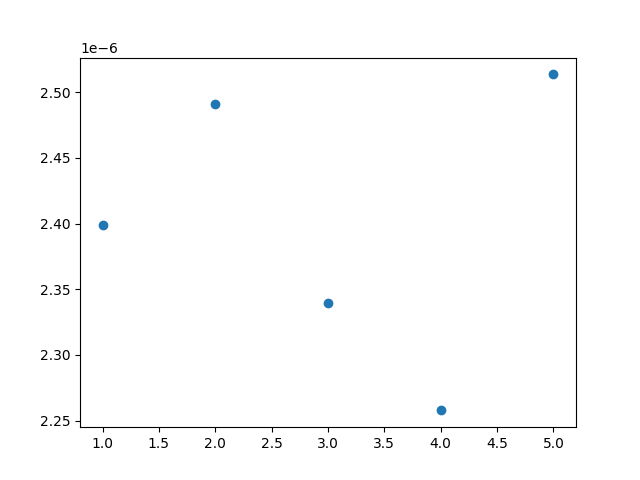

In [230]:
plt.figure()
plt.scatter(np.linspace(1,5,5),history_min)
#plt.ylim((-0.1,1))
plt.show()

In [302]:
for i in range(5):
    for j in range(i):
        this_slope_raw = xHiggs_5d_1.numpy()[:,i]/xHiggs_5d_1.numpy()[:,j]
        mask_this_slope = np.abs(this_slope_raw)<5
        this_slope = plt.hist(np.extract(mask_this_slope,this_slope_raw),bins=100)
        print(f"Slope between x{i+1} and x{j+1} : {this_slope[1][np.argmax(this_slope[0])]}")

Slope between x2 and x1 : 0.46029865741729736
Slope between x3 and x1 : -1.0710161924362183
Slope between x3 and x2 : -2.3084661960601807
Slope between x4 and x1 : 0.02834486961364746
Slope between x4 and x2 : 0.08939385414123535
Slope between x4 and x3 : -0.12943600118160248
Slope between x5 and x1 : -0.9299927353858948
Slope between x5 and x2 : -1.9003568887710571
Slope between x5 and x3 : 0.808512806892395
Slope between x5 and x4 : -4.897371768951416


In [ ]:
print(0.46047)
print(-1.)
print(0.08)
print(-0.88)

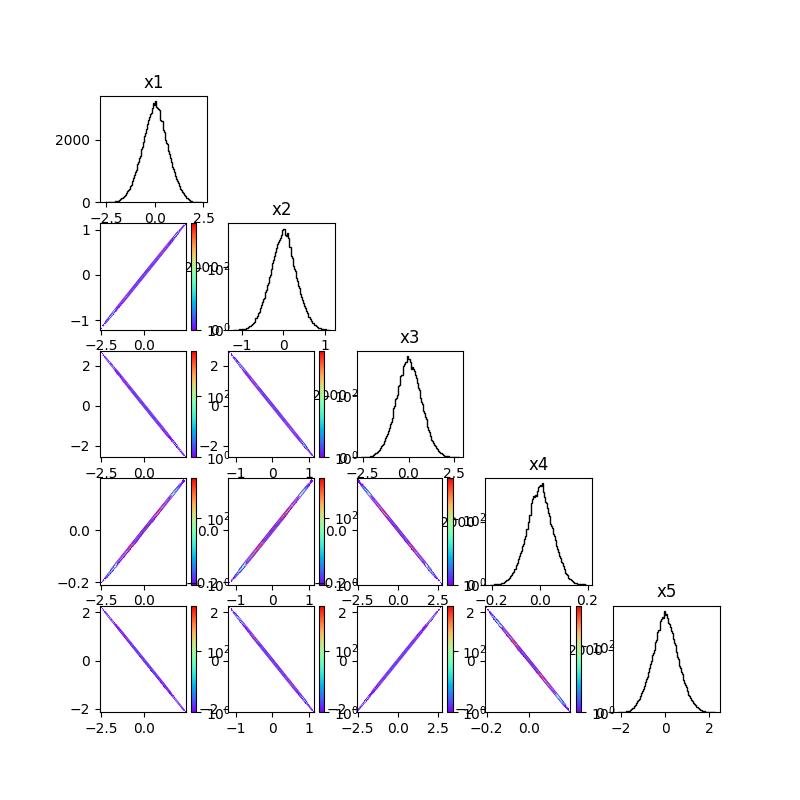

In [300]:
triangular_plot(xHiggs_5d_1.numpy(),fig_size=8)

In [247]:
# try to recover shape 

In [253]:
latent_dim = 1
input_dim = 5

inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='sigmoid')(inputs)
encoded = layers.Dense(128, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

decoded = layers.Dense(128, activation='sigmoid')(encoded)
decoded = layers.Dense(128, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

autoencoder_5d_1 = keras.Model(inputs, decoded)
autoencoder_5d_1.compile(optimizer='adam', loss='mse')

In [254]:
autoencoder_5d_1.summary()

Model: "functional_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_81 (InputLayer)     │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_526 (Dense)               │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_527 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_528 (Dense)               │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_529 (Dense)               │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_530 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_531 (Dense)               │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,822 (136.02 KB)

 Trainable params: 34,822 (136.02 KB)

 Non-trainable params: 0 (0.00 B)

In [255]:
history_5d_1 = autoencoder_5d_1.fit(set_train_5d, set_train_5d, epochs=50, batch_size=100, shuffle=True, validation_data=(set_test_5d,set_test_5d))


Epoch 1/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0959 - val_loss: 9.5842e-04
Epoch 2/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.7194e-04 - val_loss: 4.4040e-04
Epoch 3/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.0135e-04 - val_loss: 5.5523e-04
Epoch 4/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.0915e-04 - val_loss: 2.1035e-04
Epoch 5/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5436e-04 - val_loss: 2.6287e-04
Epoch 6/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5725e-04 - val_loss: 5.7244e-05
Epoch 7/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3860e-04 - val_loss: 2.4035e-04
Epoch 8/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4581e-04 - val_loss: 4.5357e-05
Epoch 9/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2621e-04 - val_loss: 1.9751e-04
Epoch 10/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3334e-04 - val_loss: 6.4497e-05
Epoch 11/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.

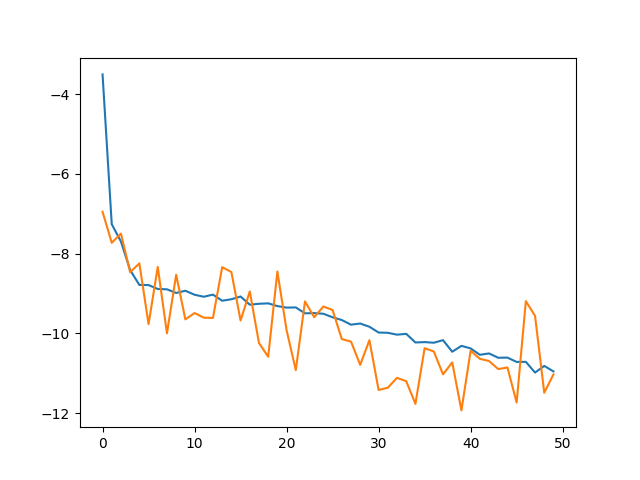

In [259]:
plt.figure()
plt.plot(np.log(history_5d_1.history["loss"]))
plt.plot(np.log(history_5d_1.history["val_loss"]))
plt.show()

In [ ]:
##########        ##########
########## 10d 1  ##########
##########        ##########

In [9]:
def V_10d_1(x):
    x1,x2,x3,x4,x5, x6, x7, x8, x9, x10 = tf.split(x,10,axis=1)
    return 0.5 * (x1 ** 3) + x10 ** 4 + 1.5 * (x1 ** 2) * x2 + 1.5 * x1 * (x2 ** 2) + 0.5 * (x2 ** 3) + 1.5 * (x1 ** 2) * (x3 ** 2) + 3 * x1 * x2 * (x3 ** 2) + 1.5 * (x2 ** 2) * (x3 ** 2) + 1.5 * x1 * (x3 ** 4) + 1.5 * x2 * (x3 ** 4) + 0.5 * (x3 ** 6) + 6 * (x1 ** 2) * (x4 ** 2) + 12 * x1 * x2 * (x4 ** 2) + 6 * (x2 ** 2) * (x4 ** 2) + 12 * x1 * (x3 ** 2) * (x4 ** 2) + 12 * x2 * (x3 ** 2) * (x4 ** 2) + 6 * (x3 ** 4) * (x4 ** 2) + 24 * x1 * (x4 ** 4) + 24 * x2 * (x4 ** 4) + 24 * (x3 ** 2) * (x4 ** 4) + 32 * (x4 ** 6) + x5 ** 4 + x6 ** 4 + x7 ** 4 + x8 ** 4 + x9 ** 4


In [10]:
# randomly initialize the points
n_points = 100000
xHiggs_10d_1 = tf.Variable(4*np.random.rand(n_points, 10)-2, dtype=tf.float32)

historyHiggs_10d_1 = []

In [1025]:
# Oprimizer for the gradient descent

init_alpha=10**(-7)
alpha = init_alpha

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

#update_alpha = False
update_opt = False 
for step in range(1000):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V_10d_1, xHiggs_10d_1)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [xHiggs_10d_1])
    
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    
    if step == 1201:
        update_opt = False 
        #optimizer.learning_rate.assign(0.001)
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [xHiggs_10d_1]))
    
    historyHiggs_10d_1.append(loss)
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-10: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Step 0: ||∇V||^2 = 2.756305320872343e-06 with learning rate 1.0000000116860974e-07
Step 10: ||∇V||^2 = 2.3310244614549447e-06 with learning rate 1.0000000116860974e-07
Step 20: ||∇V||^2 = 2.155560878236429e-06 with learning rate 1.0000000116860974e-07
Step 30: ||∇V||^2 = 2.1090659174660686e-06 with learning rate 1.0000000116860974e-07
Step 40: ||∇V||^2 = 2.0433553800103255e-06 with learning rate 1.0000000116860974e-07
Step 50: ||∇V||^2 = 2.0450293050089385e-06 with learning rate 1.0000000116860974e-07
Step 60: ||∇V||^2 = 2.023222350544529e-06 with learning rate 1.0000000116860974e-07
Step 70: ||∇V||^2 = 1.9752349089685595e-06 with learning rate 1.0000000116860974e-07
Step 80: ||∇V||^2 = 1.98152952179953e-06 with learning rate 1.0000000116860974e-07
Step 90: ||∇V||^2 = 1.9563326532079373e-06 with learning rate 1.0000000116860974e-07
Step 100: ||∇V||^2 = 1.931528458953835e-06 with learning rate 1.0000000116860974e-07
Step 110: ||∇V||^2 = 1.9345075088494923e-06 with learning rate 1.000000

Step 960: ||∇V||^2 = 1.7834029222285608e-06 with learning rate 1.0000000116860974e-07
Step 970: ||∇V||^2 = 1.7704401216178667e-06 with learning rate 1.0000000116860974e-07
Step 980: ||∇V||^2 = 1.7661677702562883e-06 with learning rate 1.0000000116860974e-07
Step 990: ||∇V||^2 = 1.770780954757356e-06 with learning rate 1.0000000116860974e-07


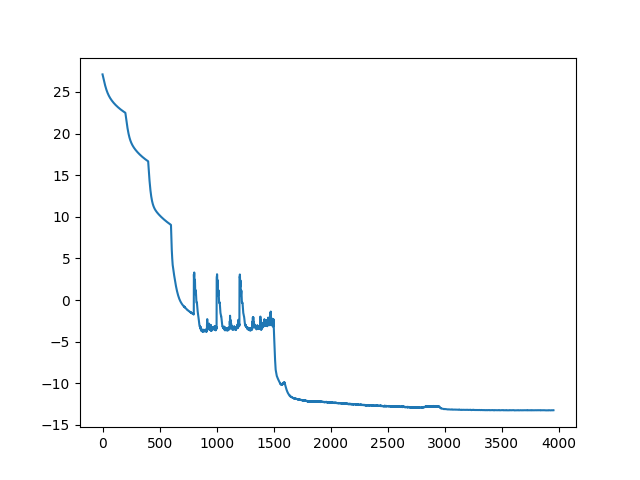

In [1031]:
plt.figure()
plt.plot(np.log(historyHiggs_10d_1))
plt.show()

In [1032]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(V_10d_1,xHiggs_10d_1)**2,axis=1).numpy()>10**(-i))}")
          

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 0
Number of points with ||∇V||^2 > 1e-07 : 0
Number of points with ||∇V||^2 > 1e-08 : 1
Number of points with ||∇V||^2 > 1e-09 : 204
Number of points with ||∇V||^2 > 1e-10 : 2756
Number of points with ||∇V||^2 > 1e-11 : 13755
Number of points with ||∇V||^2 > 1e-12 : 34692
Number of points with ||∇V||^2 > 1e-13 : 66405
Number of points with ||∇V||^2 > 1e-14 : 100000


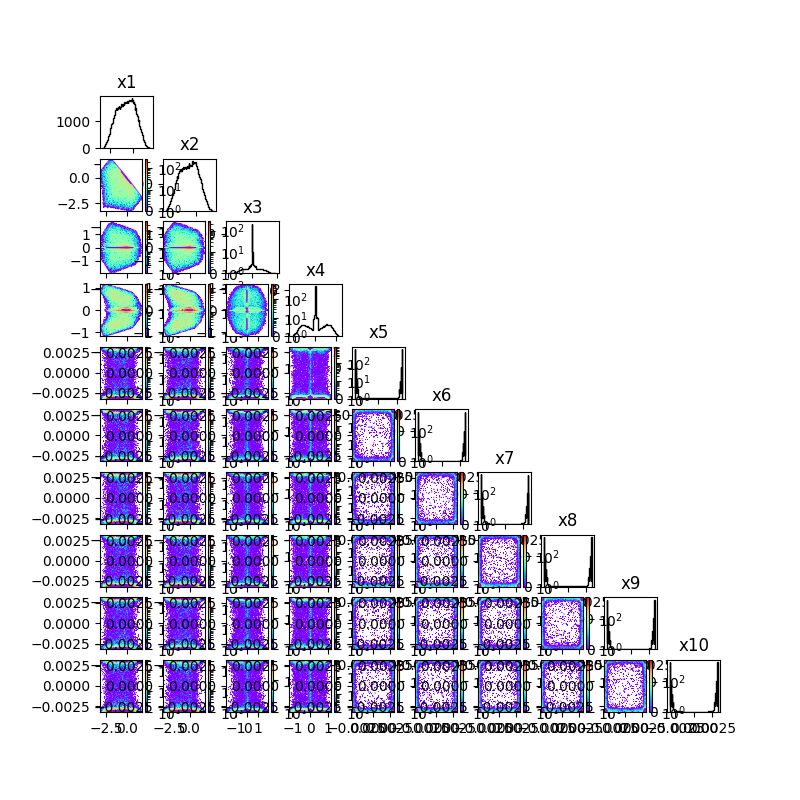

In [1033]:
triangular_plot(xHiggs_10d_1.numpy(),fig_size=8)

In [1034]:
x0grad = xHiggs_10d_1.numpy()[:,0]
x1grad = xHiggs_10d_1.numpy()[:,1]
x2grad = xHiggs_10d_1.numpy()[:,2]
x3grad = xHiggs_10d_1.numpy()[:,3]

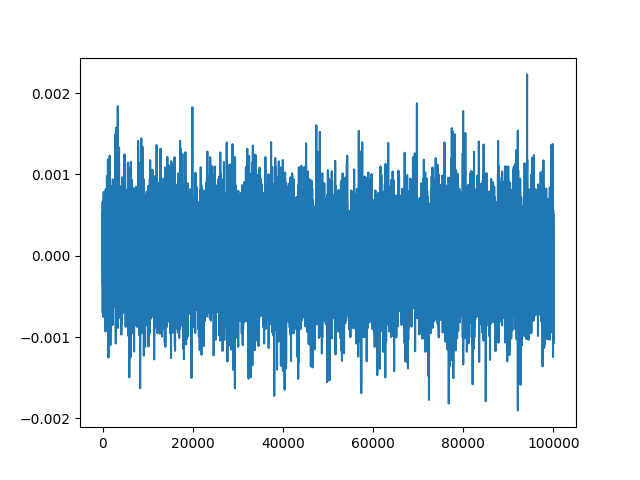

In [1035]:
plt.figure()
plt.plot(x0grad + x1grad + x2grad**2 + 4*x3grad**2)
plt.show()

In [16]:
set_train_10d_1, set_test_10d_1 = train_test_split(xHiggs_10d_1.numpy(), test_size=0.1, random_state=1)


In [18]:
history_all_10d_1 = []

for i in range(10):
    
    this_latent_dim = i + 1
    input_dim = 10
    
    print(this_latent_dim)

    inputs = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='sigmoid')(inputs)
    encoded = layers.Dense(128, activation='sigmoid')(encoded)
    encoded = layers.Dense(128, activation='sigmoid')(encoded)
    encoded = layers.Dense(this_latent_dim)(encoded)  

    decoded = layers.Dense(128, activation='sigmoid')(encoded)
    decoded = layers.Dense(128, activation='sigmoid')(decoded)
    encoded = layers.Dense(128, activation='sigmoid')(encoded)
    decoded = layers.Dense(input_dim)(decoded)  

    this_autoencoder = keras.Model(inputs, decoded)
    this_autoencoder.compile(optimizer='adam', loss='mse')
    
    history_all_10d_1.append(this_autoencoder.fit(set_train_10d_1, set_train_10d_1, epochs=100, batch_size=100, shuffle=True, validation_data=(set_test_10d_1,set_test_10d_1)))


1
Epoch 1/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2185 - val_loss: 0.1360
Epoch 2/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1363 - val_loss: 0.1358
Epoch 3/100
195/900 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1367

KeyboardInterrupt: 

In [203]:
history_min = []
for this_history in history_all_10d_1: 
    this_min = np.min(this_history.history['val_loss'])
    history_min.append(this_min)

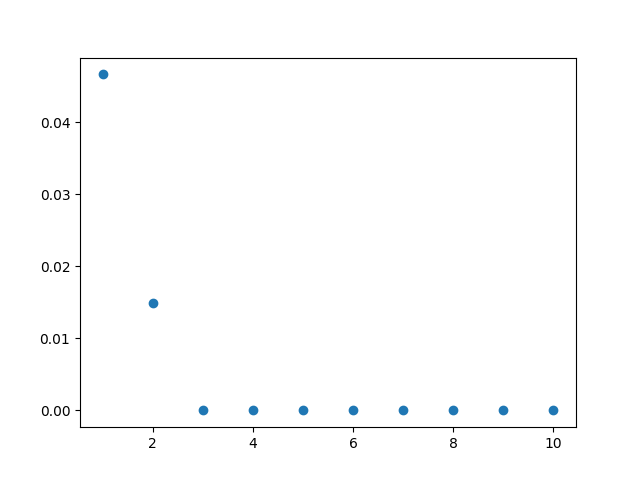

In [210]:
plt.figure()
plt.scatter(np.linspace(1,10,10),history_min)
#plt.ylim((-0.1,1))
plt.show()

In [ ]:
#Try to recover manifold

In [19]:
latent_dim = 3
input_dim = 10

inputs_10d_1 = layers.Input(shape=(input_dim,))
encoded_10d_1 = layers.Dense(256, activation='sigmoid')(inputs_10d_1)
encoded_10d_1 = layers.Dense(256, activation='sigmoid')(encoded_10d_1)
#encoded_10d_1 = layers.Dense(128, activation='sigmoid')(encoded_10d_1)
encoded_10d_1 = layers.Dense(latent_dim)(encoded_10d_1)  

decoded_10d_1 = layers.Dense(256, activation='sigmoid')(encoded_10d_1)
decoded_10d_1 = layers.Dense(256, activation='sigmoid')(decoded_10d_1)
#decoded_10d_1 = layers.Dense(128, activation='sigmoid')(decoded_10d_1)
decoded_10d_1 = layers.Dense(input_dim)(decoded_10d_1)  

autoencoder_10d_1 = keras.Model(inputs_10d_1, decoded_10d_1)
autoencoder_10d_1.compile(optimizer='adam', loss='mse')
autoencoder_10d_1.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           771 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,765 (542.05 KB)

 Trainable params: 138,765 (542.05 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_10d_1 = autoencoder_10d_1.fit(set_train_10d_1, set_train_10d_1, epochs=100, batch_size=100, shuffle=True, validation_data=(set_test_10d_1,set_test_10d_1))


Epoch 1/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1555 - val_loss: 0.0274
Epoch 2/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0275 - val_loss: 0.0290
Epoch 3/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0270 - val_loss: 0.0266
Epoch 4/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0268 - val_loss: 0.0265
Epoch 5/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0267 - val_loss: 0.0257
Epoch 6/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0244 - val_loss: 0.0143
Epoch 7/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0126 - val_loss: 0.0078
Epoch 8/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0074 - val_loss: 0.0132
Epoch 9/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0070 - val_loss: 0.0049
Epoch 10/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 11/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 12/100
900/900 ━━━━━━━━━━━━━━━━━━━━

In [21]:
history_loss = history_10d_1.history['loss']
history_val_loss = history_10d_1.history['val_loss']

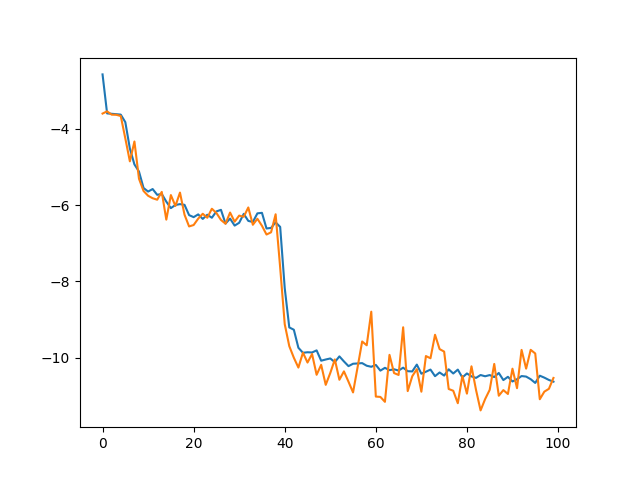

In [23]:
plt.figure()
plt.plot(np.log(history_10d_1.history['loss']))
plt.plot(np.log(history_10d_1.history['val_loss']))
plt.show()


In [24]:
encoder_10d_1 = models.Model(inputs_10d_1, encoded_10d_1)

latent_inputs_10d_1 = layers.Input(shape=(latent_dim,)) 
decoded_layer_10d_1 = autoencoder_10d_1.layers[-3](latent_inputs_10d_1)  
#decoded_layer_10d_1 = autoencoder_10d_1.layers[-3](decoded_layer_10d_1) 
decoded_layer_10d_1 = autoencoder_10d_1.layers[-2](decoded_layer_10d_1)  
decoded_output_10d_1 = autoencoder_10d_1.layers[-1](decoded_layer_10d_1) 

decoder_10d_1 = models.Model(latent_inputs_10d_1, decoded_output_10d_1)


In [25]:
encoded_points_10d_1 = encoder_10d_1.predict(set_test_10d_1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [26]:
decoded_points_10d_1 = decoder_10d_1.predict(encoded_points_10d_1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [27]:
decoded_points_10d_1_full_ae = autoencoder_10d_1.predict(set_test_10d_1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [901]:
n_points_excite = 10000
bound = 5
excite_y0_raw = np.linspace(-0,bound,n_points_excite)
excite_y0 = np.zeros((n_points_excite,3))
excite_y0[:,0] += excite_y0_raw

excite_y1_raw = np.linspace(-0,bound,n_points_excite)
excite_y1 = np.zeros((n_points_excite,3))
excite_y1[:,1] += excite_y1_raw

excite_y2_raw = np.linspace(-0,bound,n_points_excite)
excite_y2 = np.zeros((n_points_excite,3))
excite_y2[:,2] += excite_y2_raw

In [902]:
decoded_points_10d_1_y0 = decoder_10d_1.predict(excite_y0)
decoded_points_10d_1_y1 = decoder_10d_1.predict(excite_y1)
decoded_points_10d_1_y2 = decoder_10d_1.predict(excite_y2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


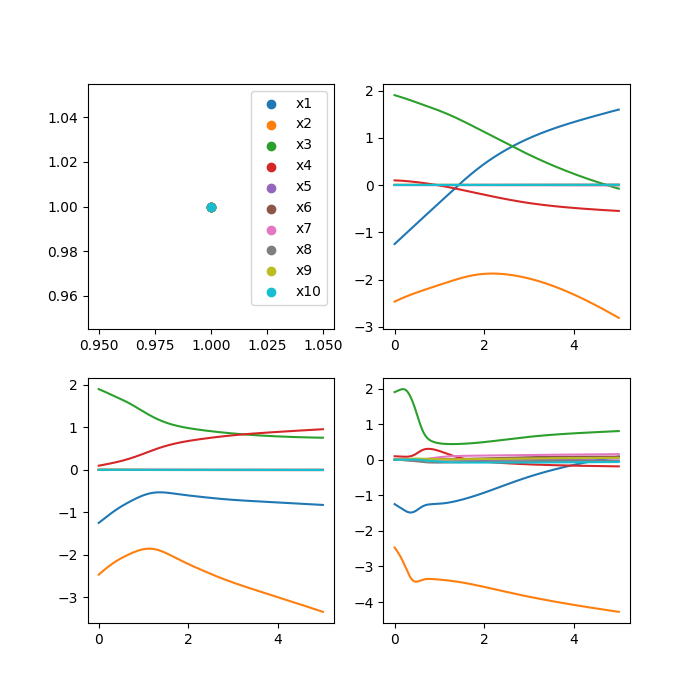

In [903]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
for i in range(10):
    ax1.scatter(1,1,label = f"x{i+1}")
    ax2.plot(excite_y0_raw,decoded_points_10d_1_y0[:,i])
    ax3.plot(excite_y0_raw,decoded_points_10d_1_y1[:,i])
    ax4.plot(excite_y0_raw,decoded_points_10d_1_y2[:,i])

ax1.legend()
plt.show()

In [904]:
#### x1 + x2 + x3**2 + 4 x4**2 = 0 ####

In [905]:
###### Try to reconstruct with NN

In [906]:
x00 = decoded_points_10d_1_y0[:,0]
x10 = decoded_points_10d_1_y0[:,1]
x20 = decoded_points_10d_1_y0[:,2]
x30 = decoded_points_10d_1_y0[:,3]
#+decoded_points_10d_1_y0[:,4]+decoded_points_10d_1_y0[:,5]+decoded_points_10d_1_y0[:,6]+decoded_points_10d_1_y0[:,7]+decoded_points_10d_1_y0[:,8]+decoded_points_10d_1_y0[:,9]

x01 = decoded_points_10d_1_y1[:,0]
x11 = decoded_points_10d_1_y1[:,1]
x21 = decoded_points_10d_1_y1[:,2]
x31 = decoded_points_10d_1_y1[:,3]
x02 = decoded_points_10d_1_y2[:,0]
x12 = decoded_points_10d_1_y2[:,1]
x22 = decoded_points_10d_1_y2[:,2]
x32 = decoded_points_10d_1_y2[:,3]

x0 = np.concatenate((x00,x01,x02))
x1 = np.concatenate((x10,x11,x12))
x2 = np.concatenate((x20,x21,x22))
x3 = np.concatenate((x30,x31,x32))

In [907]:
all_x = [x01,x11,x21,x31]

In [908]:
import itertools

n = 4
sequence_4 = list(range(0, n))
permutations_4 = list(itertools.permutations(sequence_4))

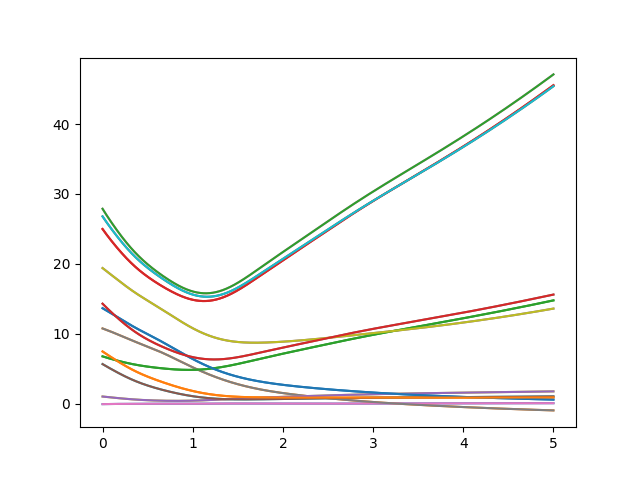

In [910]:
plt.figure()
sum_all=[]
for i in permutations_4:
    sum_all.append(np.sum(np.abs(all_x[i[0]]+all_x[i[1]]+all_x[i[2]]**2+4*all_x[i[3]]**2)))
    plt.plot(excite_y0_raw,all_x[i[0]]+all_x[i[1]]+all_x[i[2]]**2 + 4*all_x[i[3]]**2)
plt.show()

In [911]:
permutations_4[np.argmin(sum_all)]

(0, 1, 2, 3)

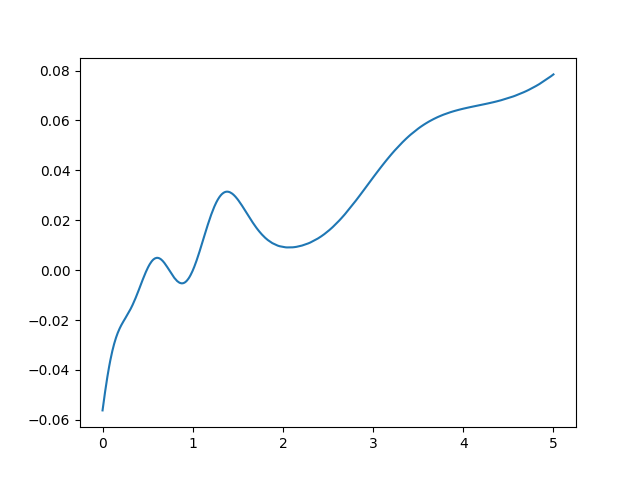

In [912]:
#this_perm = permutations_4[np.argmin(sum_all)]
this_perm = (0,1,2,3)
plt.figure()
plt.plot(excite_y0_raw,all_x[this_perm[0]]+all_x[this_perm[1]]+all_x[this_perm[2]]**2+4*all_x[this_perm[3]]**2)
plt.show()

In [1124]:
Y = np.array([x0grad]).T
X = np.array([x1grad,x2grad,x3grad]).T

#X = np.array([x1,x2,x3]).T
#Y = np.array(x0).T

lambda_reg = 0
#10**(-5)

n_neurons = 512

model_lin = tf.keras.Sequential([
    layers.Input(shape=(3,)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    #layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg))  
])
model_squared = tf.keras.Sequential([
    layers.Input(shape=(3,)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg))  
])
model_cubed = tf.keras.Sequential([
    layers.Input(shape=(3,)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg))  
])
model_4th = tf.keras.Sequential([
    layers.Input(shape=(3,)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg))  
])

model_lin.compile(optimizer=keras.optimizers.Adam(learning_rate=10**(-3)), loss='mse')
model_squared.compile(optimizer='adam', loss='mse')
model_cubed.compile(optimizer='adam', loss='mse')
model_4th.compile(optimizer='adam', loss='mse')


In [1125]:
history_loss_lin = []
#history_loss_squared = []
#history_loss_cubed = []
#history_loss_4th = []

In [1143]:
model_lin.compile(optimizer=keras.optimizers.Adam(learning_rate=10**(-5)), loss='mse')

In [1159]:
t1 = time.time()

hist_loss_lin = model_lin.fit(X, Y, epochs=50, batch_size=100)
#hist_loss_squared = model_squared.fit(X, Y**2, epochs=50, batch_size=100)
#hist_loss_cubed = model_cubed.fit(X, Y**3, epochs=50, batch_size=100)
#hist_loss_4th = model_cubed.fit(X, Y**4, epochs=50, batch_size=100)

t2 = time.time()

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.1280e-06
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.1933e-06
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.0998e-06
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.1397e-06
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.0963e-06
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.1400e-06
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.1758e-06
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.1317e-06
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1.1209e-06
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.1014e-06
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1.0765e-06
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1.1314e-06
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1.0651e-06
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 

In [1160]:
print(t2-t1)

316.92823481559753


In [1161]:
history_loss_lin += hist_loss_lin.history["loss"]
#history_loss_squared += hist_loss_squared.history["loss"]
#history_loss_cubed += hist_loss_cubed.history["loss"]
#history_loss_4th += hist_loss_4th.history["loss"]

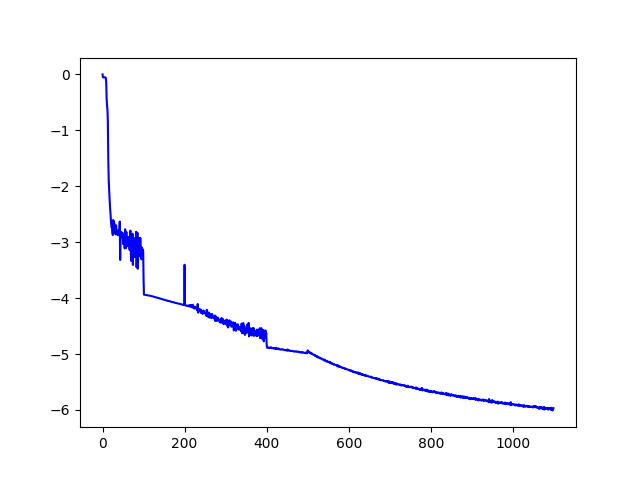

In [1162]:
plt.figure()
plt.plot(np.log(history_loss_lin)/np.log(10),c='b')
#plt.plot(np.log(history_loss_squared),c='orange')
#plt.plot(np.log(history_loss_cubed),c='r')
#plt.plot(np.log(history_loss_4th),c='yellow')
plt.show()

In [1163]:
x00_pred_lin = model_lin.predict(X)
#x00_pred_squared = model_squared.predict(X)
#x00_pred_cubed = model_cubed.predict(X)
#x00_pred_4th = model_4th.predict(X)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


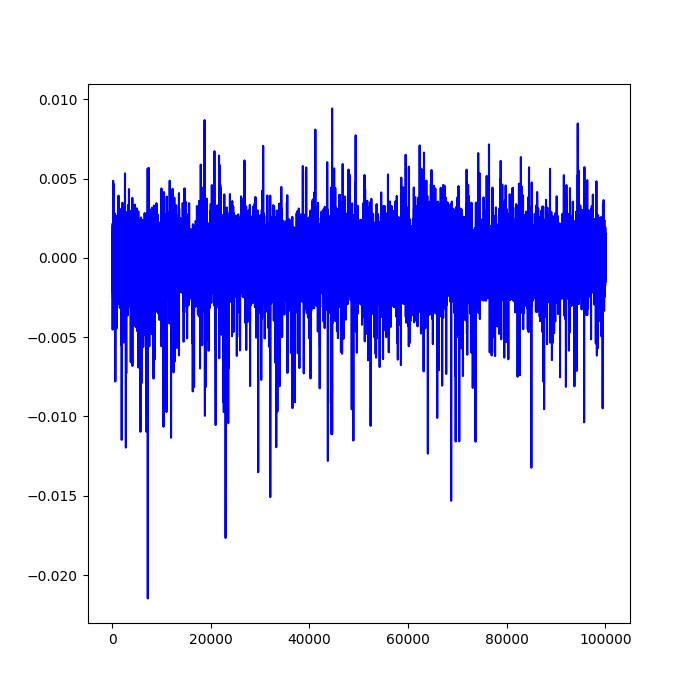

In [1164]:
plt.figure(figsize=(7,7))
plt.plot(x0grad[:]-x00_pred_lin[:,0],c='b')
#plt.plot(x00_pred_lin[:,0]+x1grad+x2grad**2+4*x3grad**2,c='orange')
#plt.plot(excite_y0_raw,,c='b',linestyle='dashed')
#plt.plot(excite_y0_raw,x01-x00_pred_lin[10000:20000],c='r')
#plt.plot(excite_y0_raw,,c='r',linestyle='dashed')
#plt.plot(excite_y0_raw,x02-x00_pred_lin[20000:30000],c='orange')
#plt.plot(excite_y0_raw,,c='orange',linestyle='dashed')
#plt.plot(excite_y0_raw,x00_pred_squared)
#plt.plot(excite_y0_raw,x00_pred_cubed**(1./3))
#plt.plot(excite_y0_raw,x00_pred_4th**(1./4))
plt.show()

In [1165]:
w0, b0 = model_lin.layers[0].get_weights()
w1, b1 = model_lin.layers[1].get_weights()
w2, b2 = model_lin.layers[2].get_weights()
#w3, b3 = model_lin.layers[3].get_weights()

In [1166]:
print(w0.shape,b0.shape)
print(w1.shape,b1.shape)
print(w2.shape,b2.shape)
#print(w3.shape,b3.shape)

(3, 512) (512,)
(512, 512) (512,)
(512, 1) (1,)


In [1167]:
np.savetxt("w0_model_10d_pot_3.csv", w0, delimiter=",",fmt="%.6f")
np.savetxt("w1_model_10d_pot_3.csv", w1, delimiter=",",fmt="%.6f")
np.savetxt("w2_model_10d_pot_3.csv", w2, delimiter=",",fmt="%.6f")
#np.savetxt("w3_model_10d_pot_2.csv", w2, delimiter=",",fmt="%.6f")
np.savetxt("b0_model_10d_pot_3.csv", b0, delimiter=",",fmt="%.6f")
np.savetxt("b1_model_10d_pot_3.csv", b1, delimiter=",",fmt="%.6f")
np.savetxt("b2_model_10d_pot_3.csv", b2, delimiter=",",fmt="%.6f")
#np.savetxt("b3_model_10d_pot_2.csv", b2, delimiter=",",fmt="%.6f")


In [1089]:
model_lin.summary()

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_333 (Dense)               │ (None, 1024)           │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_336 (Dense)               │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,312,965 (24.08 MB)

 Trainable params: 2,104,321 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,208,644 (16.05 MB)

In [ ]:
######

In [1172]:
import numpy as np
from itertools import combinations_with_replacement

def generate_polynomial_10(x, *coeffs):
    """
    Génère un polynôme de plusieurs variables à partir des données d'entrée et des coefficients.
    
    :param x: tableau de dimension (n_var, n_sample) où chaque ligne correspond à une variable et chaque colonne à un échantillon.
    :param deg: degré du polynôme.
    :param coeffs: coefficients du polynôme. Si None, les coefficients seront fixés à 1.
    :return: tableau (1, n_sample) du polynôme évalué sur chaque échantillon.
    """
    deg = 4
    n_var, n_sample = x.shape

    # Générer toutes les combinaisons des variables avec répétition jusqu'à un certain degré
    terms = []
    combs = []
    for d in range(deg+1):
        for comb in combinations_with_replacement(range(n_var), d):
            term = np.prod(x[comb, :], axis=0)
            terms.append(term)
            combs.append(comb)  

    polynomial_terms = np.array(terms)

    if coeffs is None:
        coeffs = np.ones(polynomial_terms.shape[0])
    #else:
    #    if len(coeffs) != polynomial_terms.shape[0]:
    #        raise ValueError(f"Le nombre de coefficients ({len(coeffs)}) ne correspond pas au nombre de termes générés ({polynomial_terms.shape[0]}).")

    # Multiplier chaque terme par le coefficient correspondant
    polynomial = np.dot(coeffs, polynomial_terms)

    return polynomial

In [1173]:
deg_x0 = 1
popt0, pcov0 = curve_fit(generate_polynomial_10,np.array([x1,x2,x3]),x0**deg_x0,p0=np.array([0,-1,0,0,0,0,1,0,0,-4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]))


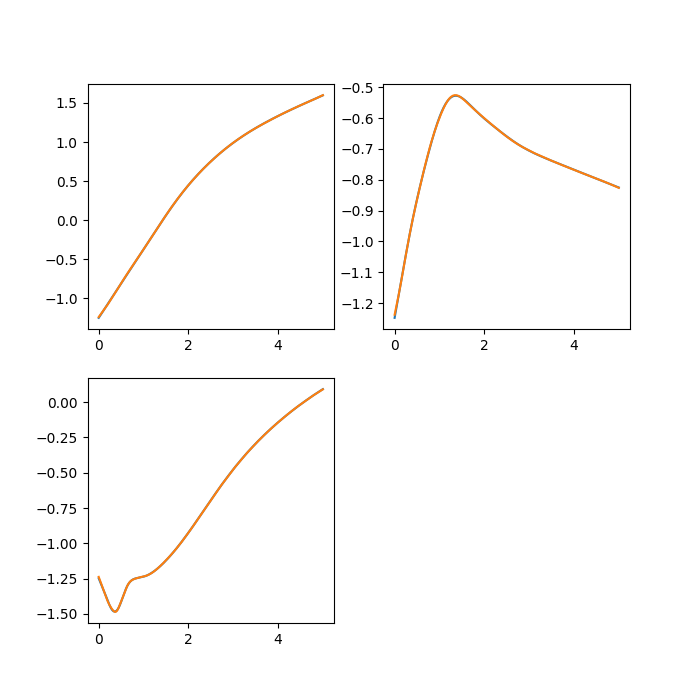

In [1175]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(2,2,1)
ax1.plot(excite_y0_raw,x00**deg_x0)
ax1.plot(excite_y0_raw,generate_polynomial_10(np.array([x10,x20,x30]),popt0)[0,:])

ax2 = fig.add_subplot(2,2,2)
ax2.plot(excite_y0_raw,x01**deg_x0)
ax2.plot(excite_y0_raw,generate_polynomial_10(np.array([x11,x21,x31]),popt0)[0,:])

ax3 = fig.add_subplot(2,2,3)
ax3.plot(excite_y0_raw,x02**deg_x0)
ax3.plot(excite_y0_raw,generate_polynomial_10(np.array([x12,x22,x32]),popt0)[0,:])

In [1176]:
popt0

array([-5.33137575e+01, -3.84497505e+01,  6.59097097e+01, -3.55508698e+01,
       -1.03413237e+01,  5.11693050e+01, -2.89089611e+00, -1.01142739e+01,
        3.96603223e+01,  9.80532091e+01, -1.07138804e+00,  1.35902567e+01,
        5.34960120e+00, -9.72246141e+00,  7.30958566e+00,  4.54062578e+01,
       -3.92139562e+00, -1.92700294e+01, -2.81660835e+01, -1.76821207e+01,
       -5.78330790e-03,  1.35083304e+00,  9.19620259e-01, -1.22195447e+00,
       -4.73803508e-01,  4.63412713e+00,  2.89857324e-01,  6.91719457e-02,
       -7.54402602e+00, -7.46630872e+00,  6.84989053e-01,  6.49156411e+00,
       -1.70168477e+00,  7.43588670e+00, -6.44395528e+00])

In [ ]:
# Tend to overfit ! 

In [ ]:
#npoints_y0y1 = 50
#col1 = np.tile(np.linspace(0, 2, npoints_y0y1), npoints_y0y1)  
#col2 = np.repeat(np.linspace(0, 2, npoints_y0y1), npoints_y0y1) 
#col3 = np.zeros(npoints_y0y1 * npoints_y0y1)  

#excite_y0y1 = np.column_stack((col1, col2, col3))

#print(excite_y0y1.shape)  

In [1182]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################

In [1183]:
##########        ##########
########## 10d 2  ##########
##########        ##########

In [1188]:
def V_10d_2(x):
    x1,x2,x3,x4,x5, x6, x7, x8, x9, x10 = tf.split(x, 10, axis = 1)
    return (x3 + x5 + x7) ** 4 + (-x1 + x10 -x3 + x4 -x5 -x7 + x8) ** 4 + 0.5 * ((x10 -x2 + x5 -x6 -x8 + 4 * ((x1 + x2 -x4 -x6 -x7 + x8) ** 2) + (-x1 + x2 -x5 -x6 + x7 + x8 -x9) ** 2) ** 3) + (-x3 -x4 + x5 -x6 -x9) ** 4 + (-x1 + x2 + x3 + x4 + x5 -x6 -x7 -x8 -x9) ** 4 + (x1 + x10 -x2 -x6 + x8 -x9) ** 4 + (x1 + x3 + x4 + x5 + x6 + x8 + x9) ** 4


In [1189]:
# randomly initialize the points
n_points = 100000
xHiggs_10d_2 = tf.Variable(4*np.random.rand(n_points, 10)-2, dtype=tf.float32)

historyHiggs_10d_2 = []

In [1202]:
# Oprimizer for the gradient descent

init_alpha=10**(-3)
alpha = init_alpha

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

update_opt = False

for step in range(1500):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V_10d_2, xHiggs_10d_2)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [xHiggs_10d_2])
    
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    
    if step == 1201:
        update_opt = False 
        #optimizer.learning_rate.assign(0.001)
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [xHiggs_10d_2]))
    
    historyHiggs_10d_2.append(loss)
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-10: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Step 0: ||∇V||^2 = 0.6236550807952881 with learning rate 0.0010000000474974513
Step 10: ||∇V||^2 = 0.8379379510879517 with learning rate 0.0010000000474974513
Step 20: ||∇V||^2 = 0.6730852723121643 with learning rate 0.0010000000474974513
Step 30: ||∇V||^2 = 0.6303998231887817 with learning rate 0.0010000000474974513
Step 40: ||∇V||^2 = 0.6069513559341431 with learning rate 0.0010000000474974513
Step 50: ||∇V||^2 = 0.595422625541687 with learning rate 0.0010000000474974513
Step 60: ||∇V||^2 = 0.5880277156829834 with learning rate 0.0010000000474974513
Step 70: ||∇V||^2 = 0.5820822715759277 with learning rate 0.0010000000474974513
Step 80: ||∇V||^2 = 0.5764911770820618 with learning rate 0.0010000000474974513
Step 90: ||∇V||^2 = 0.5708379149436951 with learning rate 0.0010000000474974513
Step 100: ||∇V||^2 = 0.5650501251220703 with learning rate 0.0010000000474974513
Step 110: ||∇V||^2 = 0.5591116547584534 with learning rate 0.0010000000474974513
Step 120: ||∇V||^2 = 0.5530191659927368 

Step 1010: ||∇V||^2 = 0.14740997552871704 with learning rate 0.0010000000474974513
Step 1020: ||∇V||^2 = 0.1453271210193634 with learning rate 0.0010000000474974513
Step 1030: ||∇V||^2 = 0.14327940344810486 with learning rate 0.0010000000474974513
Step 1040: ||∇V||^2 = 0.14126601815223694 with learning rate 0.0010000000474974513
Step 1050: ||∇V||^2 = 0.13928624987602234 with learning rate 0.0010000000474974513
Step 1060: ||∇V||^2 = 0.13733944296836853 with learning rate 0.0010000000474974513
Step 1070: ||∇V||^2 = 0.13542497158050537 with learning rate 0.0010000000474974513
Step 1080: ||∇V||^2 = 0.13354229927062988 with learning rate 0.0010000000474974513
Step 1090: ||∇V||^2 = 0.13169081509113312 with learning rate 0.0010000000474974513
Step 1100: ||∇V||^2 = 0.1298699527978897 with learning rate 0.0010000000474974513
Step 1110: ||∇V||^2 = 0.12807917594909668 with learning rate 0.0010000000474974513
Step 1120: ||∇V||^2 = 0.1263178288936615 with learning rate 0.0010000000474974513
Step 11

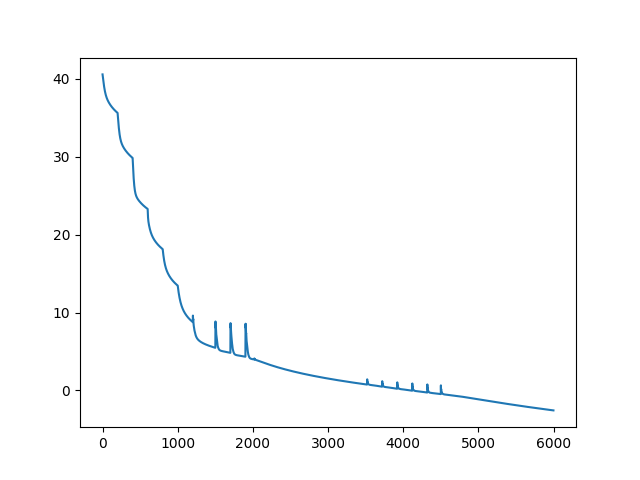

In [1203]:
plt.figure()
plt.plot(np.log(historyHiggs_10d_2))
plt.show()

In [1204]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(V_10d_2,xHiggs_10d_2)**2,axis=1).numpy()>10**(-i))}")
          

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 3
Number of points with ||∇V||^2 > 0.0001 : 98
Number of points with ||∇V||^2 > 1e-05 : 1302
Number of points with ||∇V||^2 > 1e-06 : 6603
Number of points with ||∇V||^2 > 1e-07 : 16758
Number of points with ||∇V||^2 > 1e-08 : 32472
Number of points with ||∇V||^2 > 1e-09 : 44980
Number of points with ||∇V||^2 > 1e-10 : 53653
Number of points with ||∇V||^2 > 1e-11 : 58794
Number of points with ||∇V||^2 > 1e-12 : 64242
Number of points with ||∇V||^2 > 1e-13 : 86164
Number of points with ||∇V||^2 > 1e-14 : 97917


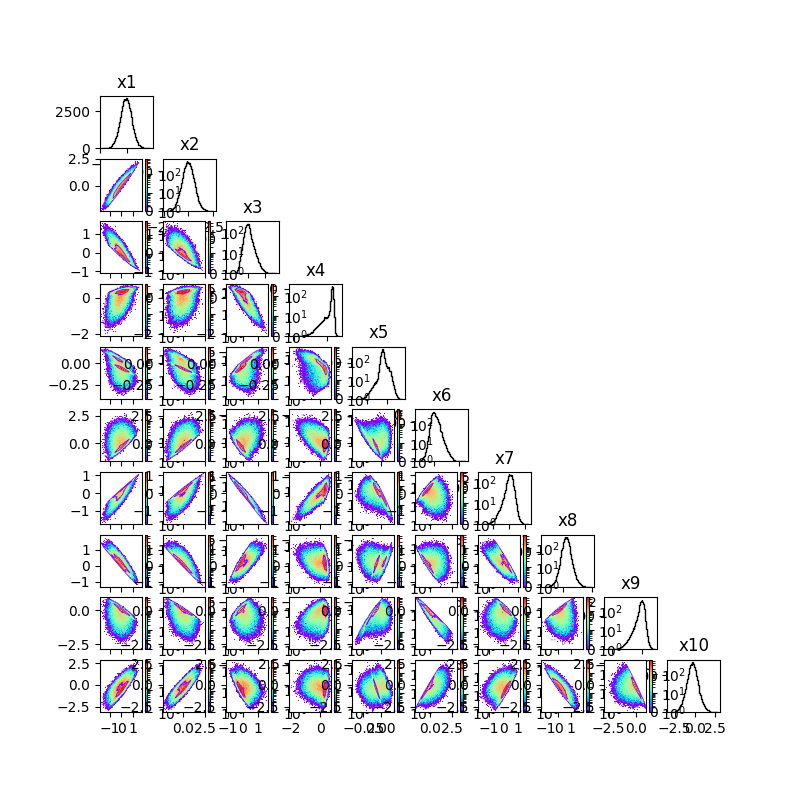

In [1231]:
triangular_plot(xHiggs_10d_2.numpy(),fig_size=8)

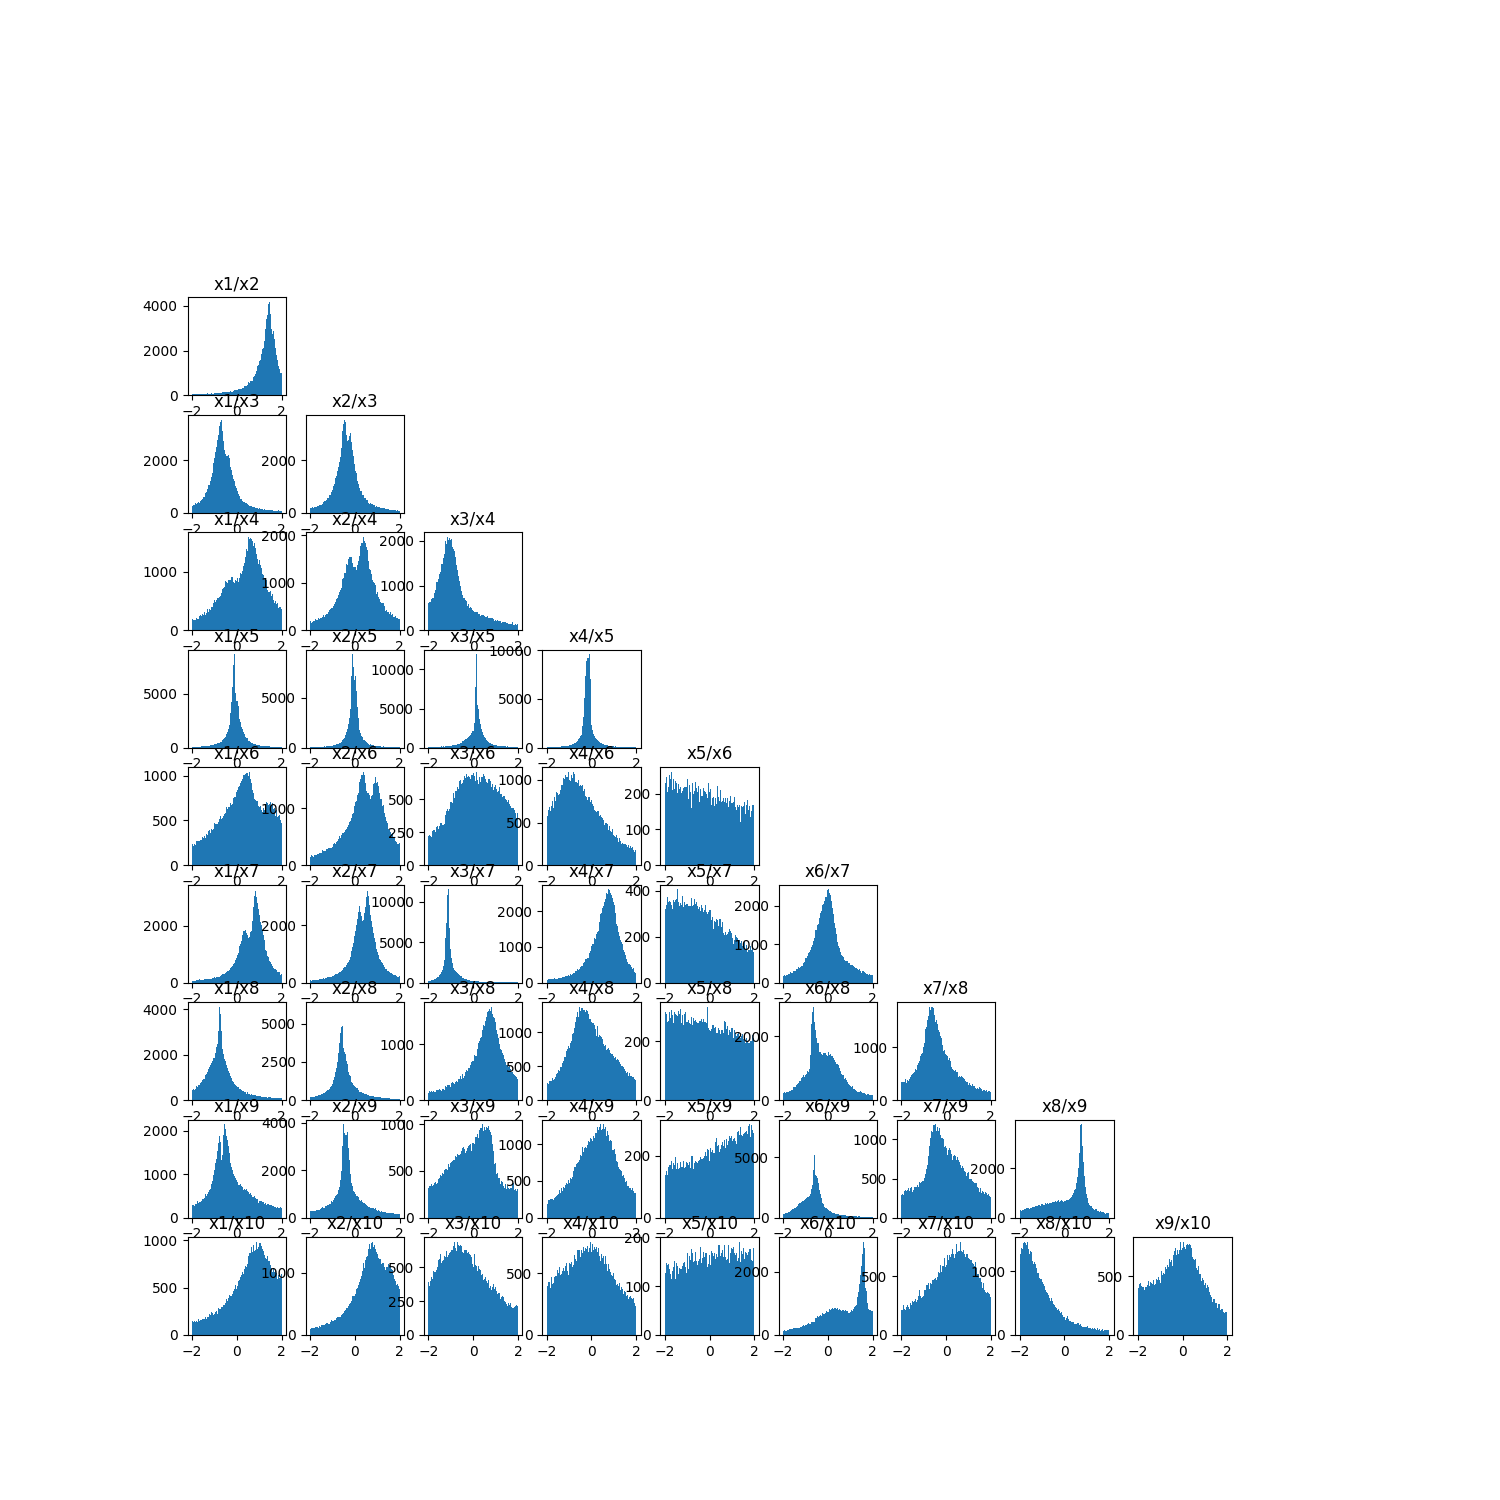

In [1237]:
triangular_plot_slopes(xHiggs_10d_2,fig_size=15,lim=2)

In [239]:
mask_train = np.array([np.random.rand()<0.9 for i in range(100000)])
set_train = np.array([np.extract(mask_train,xHiggs_10d_2.numpy()[:,i]) for i in range(10)]).T
set_test = np.array([np.extract(1-mask_train,xHiggs_10d_2.numpy()[:,i]) for i in range(10)]).T
print(set_train.shape)
print(set_test.shape)

(90054, 10)
(9946, 10)


In [240]:
history_all_10d_2 = []

for i in range(10):
    
    this_latent_dim = i + 1
    input_dim = 10
    
    print(this_latent_dim)

    inputs = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='sigmoid')(inputs)
    encoded = layers.Dense(128, activation='sigmoid')(encoded)
    encoded = layers.Dense(128, activation='sigmoid')(encoded)
    encoded = layers.Dense(this_latent_dim)(encoded)  

    decoded = layers.Dense(128, activation='sigmoid')(encoded)
    decoded = layers.Dense(128, activation='sigmoid')(decoded)
    encoded = layers.Dense(128, activation='sigmoid')(encoded)
    decoded = layers.Dense(input_dim)(decoded)  

    this_autoencoder = keras.Model(inputs, decoded)
    this_autoencoder.compile(optimizer='adam', loss='mse')
    
    history_all_10d_2.append(this_autoencoder.fit(set_train, set_train, epochs=100, batch_size=100, shuffle=True, validation_data=(set_test,set_test)))


1
Epoch 1/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1893 - val_loss: 0.1116
Epoch 2/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1100 - val_loss: 0.1121
Epoch 3/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1100 - val_loss: 0.1117
Epoch 4/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1087 - val_loss: 0.1021
Epoch 5/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0942 - val_loss: 0.0797
Epoch 6/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0768 - val_loss: 0.0742
Epoch 7/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0723 - val_loss: 0.0752
Epoch 8/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0724 - val_loss: 0.0697
Epoch 9/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0677 - val_loss: 0.0655
Epoch 10/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0652 - val_loss: 0.0653
Epoch 11/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0638 - val_loss: 0.0633
Epoch 12/100
901/901 ━━━━━━━━━━━━━━━━━━

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0128 - val_loss: 0.0149
Epoch 36/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 37/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0131 - val_loss: 0.0118
Epoch 38/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0115 - val_loss: 0.0153
Epoch 39/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0134 - val_loss: 0.0121
Epoch 40/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0131 - val_loss: 0.0122
Epoch 41/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0121 - val_loss: 0.0126
Epoch 42/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 43/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0125 - val_loss: 0.0128
Epoch 44/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0135 - val_loss: 0.0161
Epoch 45/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0163 - val_loss: 0.0153
Epoch 46/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 

901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 70/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 71/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 72/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 73/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 74/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 75/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 76/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 77/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 78/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 79/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 80/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 100/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.9199e-05 - val_loss: 2.8529e-05
5
Epoch 1/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1353 - val_loss: 0.0310
Epoch 2/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0289 - val_loss: 0.0236
Epoch 3/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0054 - val_loss: 0.0023
Epoch 4/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 5/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 10/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
901/901 ━━━━━━━━━

901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1274e-05 - val_loss: 6.8977e-05
Epoch 66/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.1998e-05 - val_loss: 9.2934e-05
Epoch 67/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.0451e-05 - val_loss: 3.0757e-05
Epoch 68/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.8321e-05 - val_loss: 3.2913e-05
Epoch 69/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0420e-05 - val_loss: 2.7820e-05
Epoch 70/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7866e-05 - val_loss: 2.6175e-05
Epoch 71/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.5472e-05 - val_loss: 6.3611e-05
Epoch 72/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8511e-05 - val_loss: 6.7722e-05
Epoch 73/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.4984e-05 - val_loss: 2.8794e-05
Epoch 74/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.7640e-05 - val_loss: 3.7566e-05
Epoch 75/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.1094e-05 - val_loss: 1.9611e-05
Epoch 93/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.0441e-05 - val_loss: 3.3359e-05
Epoch 94/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.0008e-05 - val_loss: 2.2778e-05
Epoch 95/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.9759e-05 - val_loss: 3.1473e-05
Epoch 96/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.3118e-05 - val_loss: 3.1925e-05
Epoch 97/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.2893e-05 - val_loss: 2.1694e-05
Epoch 98/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.6337e-05 - val_loss: 1.0232e-04
Epoch 99/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.2311e-05 - val_loss: 2.6719e-05
Epoch 100/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.8968e-05 - val_loss: 3.1002e-05
7
Epoch 1/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1832 - val_loss: 0.0294
Epoch 2/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss

901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.0197e-04 - val_loss: 2.0154e-04
Epoch 21/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.9864e-04 - val_loss: 2.3716e-04
Epoch 22/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.8584e-04 - val_loss: 1.6014e-04
Epoch 23/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7505e-04 - val_loss: 2.3930e-04
Epoch 24/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7416e-04 - val_loss: 1.6777e-04
Epoch 25/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7116e-04 - val_loss: 1.3147e-04
Epoch 26/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.5721e-04 - val_loss: 1.2115e-04
Epoch 27/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3861e-04 - val_loss: 1.2741e-04
Epoch 28/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3810e-04 - val_loss: 1.1359e-04
Epoch 29/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3248e-04 - val_loss: 2.0951e-04
Epoch 30/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.4987e-05 - val_loss: 1.1395e-04
Epoch 48/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.3519e-05 - val_loss: 9.3310e-05
Epoch 49/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.2146e-05 - val_loss: 4.3759e-05
Epoch 50/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.0719e-05 - val_loss: 2.8875e-05
Epoch 51/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.8672e-05 - val_loss: 5.4126e-05
Epoch 52/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7981e-05 - val_loss: 3.0128e-05
Epoch 53/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3884e-05 - val_loss: 4.3371e-05
Epoch 54/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.0525e-05 - val_loss: 3.3555e-05
Epoch 55/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.2421e-05 - val_loss: 4.6489e-05
Epoch 56/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1908e-05 - val_loss: 6.6843e-05
Epoch 57/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.8466e-05 - val_loss: 2.9435e-05
Epoch 74/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.5204e-05 - val_loss: 3.4560e-05
Epoch 75/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.4169e-05 - val_loss: 2.9636e-05
Epoch 76/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 3.3876e-05 - val_loss: 2.8358e-05
Epoch 77/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.2785e-05 - val_loss: 2.3123e-05
Epoch 78/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.6920e-05 - val_loss: 2.4305e-05
Epoch 79/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.1456e-05 - val_loss: 2.7676e-05
Epoch 80/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.7801e-05 - val_loss: 3.4354e-05
Epoch 81/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.0196e-05 - val_loss: 4.1621e-05
Epoch 82/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.4108e-05 - val_loss: 2.0287e-05
Epoch 83/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

In [241]:
history_min = []
for this_history in history_all_10d_2: 
    this_min = np.min(this_history.history['val_loss'])
    history_min.append(this_min)

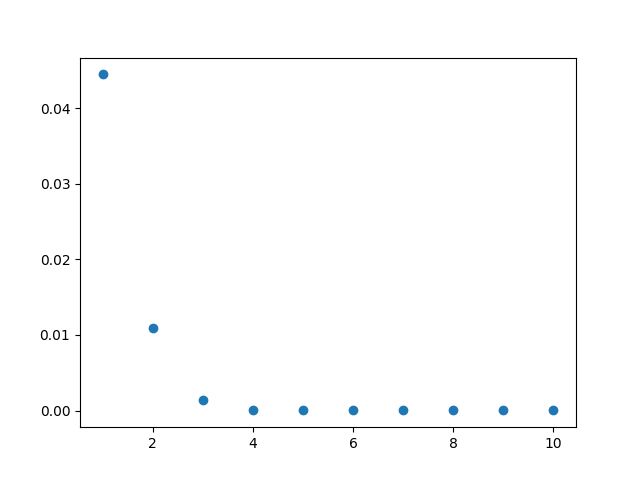

In [242]:
plt.figure()
plt.scatter(np.linspace(1,10,10),history_min)
#plt.ylim((-0.1,1))
plt.show()

In [1206]:
mask_train_10d_2 = np.array([np.random.rand()<0.9 for i in range(100000)])
set_train_10d_2 = np.array([np.extract(mask_train_10d_2,xHiggs_10d_2.numpy()[:,i]) for i in range(10)]).T
set_test_10d_2 = np.array([np.extract(1-mask_train_10d_2,xHiggs_10d_2.numpy()[:,i]) for i in range(10)]).T
print(set_train_10d_2.shape)
print(set_test_10d_2.shape)

(90015, 10)
(9985, 10)


In [1207]:
latent_dim = 3
input_dim = 10

n_neurons = 256

inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(n_neurons, activation='sigmoid')(inputs)
encoded = layers.Dense(n_neurons, activation='sigmoid')(encoded)
#encoded = layers.Dense(128, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

decoded = layers.Dense(n_neurons, activation='sigmoid')(encoded)
decoded = layers.Dense(n_neurons, activation='sigmoid')(decoded)
#decoded = layers.Dense(128, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

autoencoder_10d_2 = keras.Model(inputs, decoded)
autoencoder_10d_2.compile(optimizer='adam', loss='mse')
autoencoder_10d_2.summary()

Model: "functional_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_125 (InputLayer)    │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_396 (Dense)               │ (None, 3)              │           771 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_397 (Dense)               │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_399 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,765 (542.05 KB)

 Trainable params: 138,765 (542.05 KB)

 Non-trainable params: 0 (0.00 B)

In [1224]:
autoencoder_10d_2.compile(optimizer=keras.optimizers.Adam(learning_rate=10**(-5)), loss='mse')


In [1225]:
history_10d_2 = autoencoder_10d_2.fit(set_train_10d_2, set_train_10d_2, epochs=50, batch_size=100, shuffle=True, validation_data=(set_test_10d_2,set_test_10d_2))


Epoch 1/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.0983e-04 - val_loss: 4.8189e-04
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.0297e-04 - val_loss: 4.5796e-04
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.2415e-04 - val_loss: 4.6163e-04
Epoch 4/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.0022e-04 - val_loss: 4.6492e-04
Epoch 5/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.1031e-04 - val_loss: 4.8354e-04
Epoch 6/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.7973e-04 - val_loss: 5.1222e-04
Epoch 7/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.8088e-04 - val_loss: 4.8077e-04
Epoch 8/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.0354e-04 - val_loss: 5.0920e-04
Epoch 9/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.0424e-04 - val_loss: 4.9690e-04
Epoch 10/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.0365e-04 - val_loss: 5.1184e-04
Epoch 11/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss

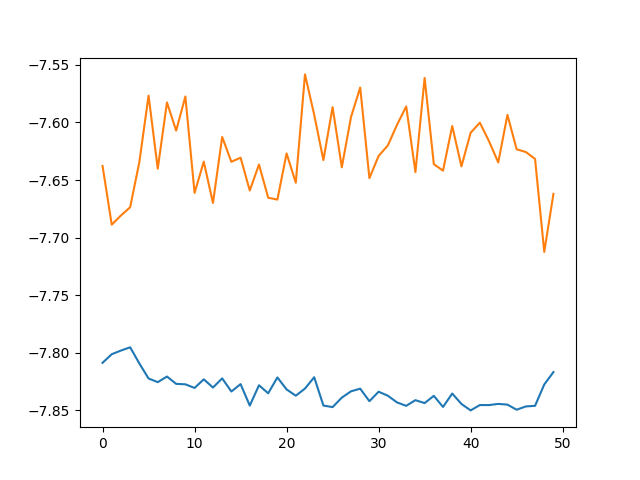

In [1226]:
plt.figure()
plt.plot(np.log(history_10d_2.history["loss"]))
plt.plot(np.log(history_10d_2.history["val_loss"]))
plt.show()


In [1228]:
encoder = models.Model(inputs, encoded)

latent_inputs = layers.Input(shape=(latent_dim,))  
#decoded_layer = autoencoder_10d_2.layers[-4](latent_inputs)
decoded_layer = autoencoder_10d_2.layers[-3](latent_inputs)
decoded_layer = autoencoder_10d_2.layers[-2](decoded_layer)
decoded_output = autoencoder_10d_2.layers[-1](decoded_layer)

decoder = models.Model(latent_inputs, decoded_output)

In [1229]:
decoded_points_10d_2_y0 = decoder.predict(excite_y0)
decoded_points_10d_2_y1 = decoder.predict(excite_y1)
decoded_points_10d_2_y2 = decoder.predict(excite_y2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


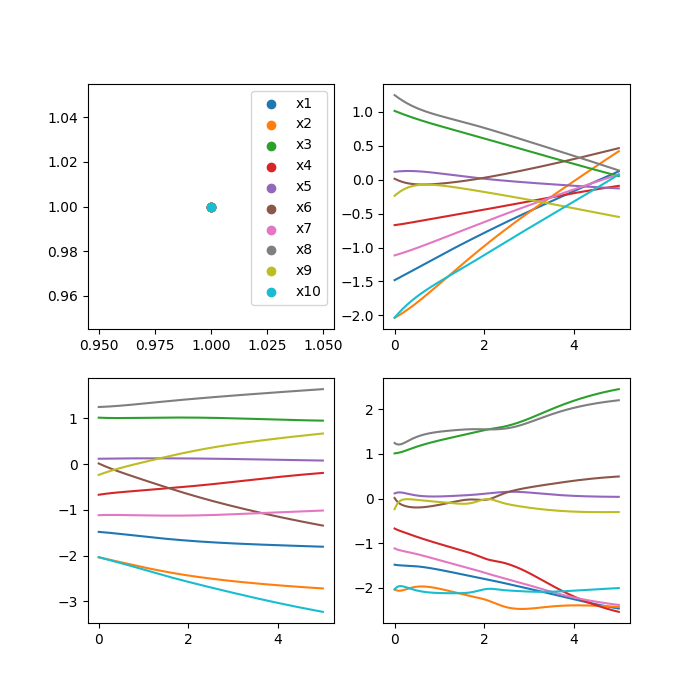

In [1230]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
for i in range(10):
    ax1.scatter(1,1,label = f"x{i+1}")
    ax2.plot(excite_y0[:,0],decoded_points_10d_2_y0[:,i])
    ax3.plot(excite_y0[:,0],decoded_points_10d_2_y1[:,i])
    ax4.plot(excite_y0[:,0],decoded_points_10d_2_y2[:,i])

ax1.legend()
plt.show()

In [1389]:
x_1_0 = xHiggs_10d_2.numpy()[:,0]
x_1_1 = xHiggs_10d_2.numpy()[:,1]
x_1_2 = xHiggs_10d_2.numpy()[:,2]
x_1_3 = xHiggs_10d_2.numpy()[:,3]
x_1_4 = xHiggs_10d_2.numpy()[:,4]
x_1_5 = xHiggs_10d_2.numpy()[:,5]
x_1_6 = xHiggs_10d_2.numpy()[:,6]
x_1_7 = xHiggs_10d_2.numpy()[:,7]
x_1_8 = xHiggs_10d_2.numpy()[:,8]
x_1_9 = xHiggs_10d_2.numpy()[:,9]


In [1251]:
Y = np.array([x_1_0]).T
X = np.array([x_1_1,x_1_2,x_1_3,x_1_4,x_1_5,x_1_6,x_1_7,x_1_8,x_1_9]).T

#X = np.array([x1,x2,x3]).T
#Y = np.array(x0).T

lambda_reg = 0
#10**(-5)

n_neurons = 128
input_shape = 9

model_lin = tf.keras.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg))  
])
model_squared = tf.keras.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg))  
])
model_cubed = tf.keras.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg))  
])
model_4th = tf.keras.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg))  
])


In [1252]:
#model_lin.compile(optimizer=keras.optimizers.Adam(learning_rate=10**(-3)), loss='mse')
model_lin.compile(optimizer='adam', loss='mse')
model_squared.compile(optimizer='adam', loss='mse')
model_cubed.compile(optimizer='adam', loss='mse')
model_4th.compile(optimizer='adam', loss='mse')

In [1253]:
history_loss_lin = []
history_loss_squared = []
history_loss_cubed = []
history_loss_4th = []

In [1254]:
t1 = time.time()

hist_loss_lin = model_lin.fit(X, Y, epochs=50, batch_size=100)
hist_loss_squared = model_squared.fit(X, Y**2, epochs=50, batch_size=100)
#hist_loss_cubed = model_cubed.fit(X, Y**3, epochs=50, batch_size=100)
#hist_loss_4th = model_cubed.fit(X, Y**4, epochs=50, batch_size=100)

t2 = time.time()

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0343
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.9340e-04
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.6888e-04
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6221e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1354e-04
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.7609e-05
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.0293e-05
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.6166e-05
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5810e-05
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5147e-05
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.4542e-05
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.5159e-05
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.3537e-05
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/s

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2789e-05
Epoch 28/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5532e-05
Epoch 29/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.5193e-05
Epoch 30/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7498e-05
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3939e-05
Epoch 32/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7320e-05
Epoch 33/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3886e-05
Epoch 34/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.4359e-05
Epoch 35/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.3449e-05
Epoch 36/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7268e-05
Epoch 37/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2923e-05
Epoch 38/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8395e-05
Epoch 39/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6380e-05
Epoch 40/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

In [1255]:
history_loss_lin += hist_loss_lin.history["loss"]
history_loss_squared += hist_loss_squared.history["loss"]
history_loss_cubed += hist_loss_cubed.history["loss"]
history_loss_4th += hist_loss_4th.history["loss"]

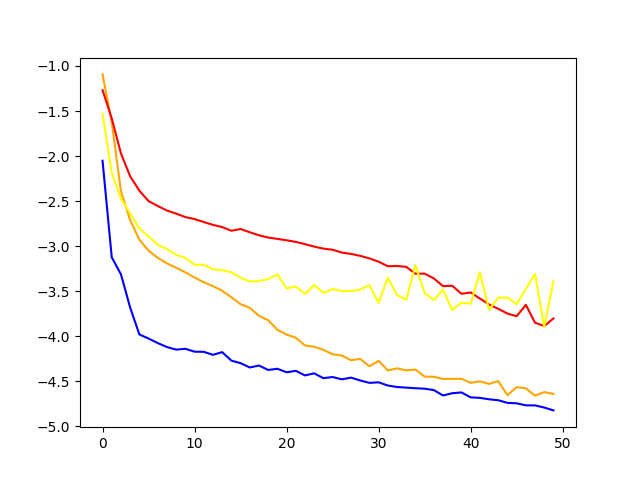

In [1256]:
plt.figure()
plt.plot(np.log(history_loss_lin)/np.log(10),c='b')
plt.plot(np.log(history_loss_squared)/np.log(10),c='orange')
plt.plot(np.log(history_loss_cubed)/np.log(10),c='r')
plt.plot(np.log(history_loss_4th)/np.log(10),c='yellow')
plt.show()

In [1329]:
Y = np.array([x_1_0]).T
X = np.array([x_1_1,x_1_2,x_1_3,x_1_4,x_1_5,x_1_6,x_1_7,x_1_8,x_1_9]).T

#X = np.array([x1,x2,x3]).T
#Y = np.array(x0).T

lambda_reg = 0
#10**(-5)

n_neurons = 256
input_shape = 9

model_lin_x_1_0 = tf.keras.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg))  
])


In [1330]:
history_loss_lin_x_1_0 = []

In [1348]:
reduce_lr = ReduceLROnPlateau(monitor='loss',
                                        factor=0.5,
                                        patience=10,
                                        min_lr=10**(-6),
                                        percentage_delta = 10**(-3))

#model_lin_x_1_0.compile(optimizer='adam', loss='mse')
model_lin_x_1_0.compile(optimizer=keras.optimizers.Adam(learning_rate=10**(-2)), loss='mse')


In [1347]:
hist_loss_lin_x_1_0 = model_lin_x_1_0.fit(X, Y, epochs=200, batch_size=100, callbacks=[reduce_lr])


Epoch 1/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0035
Epoch 2/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.8601e-05
Epoch 3/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7377e-04
Epoch 4/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5791e-04
Epoch 5/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7833e-04
Epoch 6/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6139e-04
Epoch 7/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4591e-04
Epoch 8/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4977e-04
Epoch 9/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3382e-04
Epoch 10/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3690e-04
Epoch 11/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3998e-04
Epoch 12/200
 989/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9989e-04

AttributeError: 'str' object has no attribute 'name'

In [1335]:
history_loss_lin_x_1_0 += hist_loss_lin_x_1_0.history["loss"]

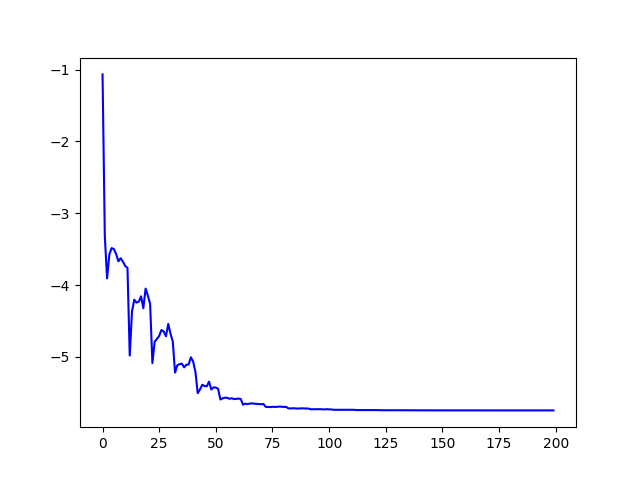

In [1336]:
plt.figure()
plt.plot(np.log(history_loss_lin_x_1_0)/np.log(10),c='b')
plt.show()

In [1306]:
w0, b0 = model_lin_x_1_0.layers[0].get_weights()
w1, b1 = model_lin_x_1_0.layers[1].get_weights()
w2, b2 = model_lin_x_1_0.layers[2].get_weights()
#w3, b3 = model_lin.layers[3].get_weights()

In [1307]:
w0, b0 = model_lin_x_1_0.layers[0].get_weights()
w1, b1 = model_lin_x_1_0.layers[1].get_weights()
w2, b2 = model_lin_x_1_0.layers[2].get_weights()
#w3, b3 = model_lin.layers[3].get_weights()
np.savetxt("w0_model_10d_pot_x_1_0.csv", w0, delimiter=",",fmt="%.6f")
np.savetxt("w1_model_10d_pot_x_1_0.csv", w1, delimiter=",",fmt="%.6f")
np.savetxt("w2_model_10d_pot_x_1_0.csv", w2, delimiter=",",fmt="%.6f")
#np.savetxt("w3_model_10d_pot_2.csv", w2, delimiter=",",fmt="%.6f")
np.savetxt("b0_model_10d_pot_x_1_0.csv", b0, delimiter=",",fmt="%.6f")
np.savetxt("b1_model_10d_pot_x_1_0.csv", b1, delimiter=",",fmt="%.6f")
np.savetxt("b2_model_10d_pot_x_1_0.csv", b2, delimiter=",",fmt="%.6f")
#np.savetxt("b3_model_10d_pot_2.csv", b2, delimiter=",",fmt="%.6f")


# Try to make the analysis systematic

In [1594]:
def find_order(X, Y, max_order = 4, n_epochs = 50, n_neurons = 128, input_shape = 9, batch_size = 100):
    
    """Function that seeks to what order a given coordinate probably appears in a polynomial. Learns Y**order in 
    terms of X, for orders in range(max_order). Then returns the losses, from which we can extract the probable
    best orders. 
        - X : x_data for the neural network. Should contain different x's which you are going to use to reconstruct
            Y. array of shape (n_var,n_samples)
        - Y : y_data. The variable we try to reconstruct with x's. array of shape (n_samples,)
        - max_order. Maximum order to analyse. int
        - n_epochs. Numbers of epoch to train the NN with. int 
        - n_neurons. The architecture is fixed to dense layers of shape (n_var,n_neurons,n_neurons,1). int
        - input_shape. Number of variables n_var. int
        - batch_size. batch_size for the training of the NN. int"""
    
    all_loss = []
    for i in range(1,max_order+1): 
        this_model = tf.keras.Sequential([
            layers.Input(shape=(input_shape,)),
            layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
            layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
            layers.Dense(1, kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg))  
])
        this_model.compile(optimizer='adam', loss='mse')
        hist_this_loss = this_model.fit(X, Y**i, epochs=n_epochs, batch_size=batch_size)
        all_loss.append([i,hist_this_loss.history["loss"]])
    return all_loss
        
def learn_one_x_from_the_others(X, Y, n_neurons = 256, order = 1, lambda_reg = 0, n_epochs = 200, batch_size = 100, factor_red_lr = 0.5):
    
    """Train a NN to learn Y**order in terms of X. The architecture is fixed to dense layers of 
    shape (n_var,n_neurons,n_neurons,1).
        - X : x_data for the neural network. Should contain different x's which you are going to use to reconstruct
            Y. array of shape (n_var,n_samples)
        - Y : y_data. The variable we try to reconstruct with x's. array of shape (n_samples,)
        - order : power to raise Y. int
        - lambda_reg : regularisation parameter for the NN. float
        - n_epochs : number of epochs for the training. int
        - batch_size : batch_size for the training. int"""
    
    X_train, X_test = train_test_split(X, test_size=0.1, random_state=1)
    Y_train, Y_test = train_test_split(Y, test_size=0.1, random_state=1)
    
    input_shape = 9
    this_model = tf.keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
        layers.Dense(n_neurons, activation='sigmoid', kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg)),
        layers.Dense(1, kernel_regularizer=regularizers.l2(lambda_reg), bias_regularizer=regularizers.l2(lambda_reg))  
        ])
    
    this_model.compile(optimizer=keras.optimizers.Adam(learning_rate=10**(-2)), loss='mse')
    
    if factor_red_lr < 1: 
        #reduce_lr = ReduceLROnPlateau(monitor='loss',
        #                              factor=factor_red_lr,
        #                              patience=10,
        #                              min_lr=10**(-6),
        #                              min_delta = 10**(-3))
        def scheduler(epoch, lr):
            if epoch < 100:
                return 10**(-2)
            elif epoch < 200:
                return 10**(-3)
            elif epoch < 300:
                return 10**(-4)
            else:
                return 10**(-5)
            
        lr_schedule = LearningRateScheduler(scheduler)
        this_hist_loss = this_model.fit(X, Y**order, epochs=n_epochs, batch_size=batch_size, callbacks=[lr_schedule],validation_data=[X_test,Y_test])
    else:
        this_hist_loss = this_model.fit(X, Y**order, epochs=n_epochs, batch_size=batch_size,validation_data=[X_test,Y_test])

    return [this_model,this_hist_loss]

def save_nn(model_to_save, name):
    """Save the NN
        - model_to_save : which NN to save. 
        - name : name under which to save NN. str"""
    index = 0
    for layer in model_to_save.layers:
        this_weights, this_baises = layer.get_weights()
        np.savetxt("systematic_analysis/w"+str(index)+"_model_"+name+".csv", this_weights, delimiter=",",fmt="%.6f")
        np.savetxt("systematic_analysis/b"+str(index)+"_model_"+name+".csv", this_baises, delimiter=",",fmt="%.6f")
        index += 1

def select_order(list_losses, tol = 0.1):
    """Find the power for a given X, Y to which we should look a polynomial : Y**order = P(X). Look for minima in 
    loss histories. 
        - list_losses : list of losses of a NN trying to learn Y**order with X, previously obtained
        - tol : select which order got smallest loss, and retain all minima with tolerance in % tol"""
    index_min = 0
    best_min = 10**8
    list_min = []
    to_explore = []
    for i in list_losses:
        index_min = 0
        this_min = np.min(i[1])
        list_min.append([i[0],this_min])
        if this_min < best_min:
            best_min  = this_min
            index_min = i[0]
    to_explore.append(index_min)
    
    for i in range(len(list_losses)):
        if i == index_min:
            continue
            
        elif list_min[i][1] * (1 - tol) < best_min:
            to_explore.append(i)
    return(to_explore)
    
def get_NN_one_x(isolate, max_order = 4, n_epochs_for_orders = 50, n_epochs_for_model = 100, tol_order = 10**(-2), save = True, n_neurons = 256):
    """Apply the different routines to get the NN for a isolated X. 
        - isolate : index of which x to isolate. int
        - max_order : maximum power to include in the analysis, ie we are going to try to reproduce Y up to 
        Y**max_order. int
        - n_epochs_for_orders : numbers of epochs for training when looking what powers should be selected. int
        - n_epochs_for_model : numbers of epochs for training when trying to reproduce Y**orders_to_analyse
        - tol_order : tolerance (in %) in the selection of the different powers to analyse. float
        - save : whether or not to save the data, bool.
        - n_neurons : number of neurons in layers for the NN when learning one X, int."""
    X = np.array([all_X[i] for i in range(isolate)]+[all_X[i] for i in range(isolate+1,10)]).T
    Y = all_X[isolate].T
    all_model_this_x = []
    all_losses_this_x = []
    best_losses_this_X = find_order(X, Y, max_order = max_order, n_epochs = n_epochs_for_orders)
        
    orders_to_analyse = select_order(best_losses_this_X, tol = tol_order)
        
    print(f"For x{isolate}, the orders to analyse are {orders_to_analyse}.")  
    for this_order in orders_to_analyse:
        print(f"For x{isolate}, analysing {this_order}.")
        model_this_order,loss_this_order = learn_one_x_from_the_others(X, Y, order=this_order+1, n_epochs = n_epochs_for_model, n_neurons = n_neurons)
        all_model_this_x.append([this_order,model_this_order])
        all_losses_this_x.append([this_order,loss_this_order])
        
        if save == True: 
            save_nn(model_this_order,"10d_x"+str(isolate)+"_order"+str(this_order))
    return [all_model_this_x,all_losses_this_x]

def get_all_NN(all_X, max_order = 4, n_epochs_for_orders = 50, n_epochs_for_model = 100, tol_order = 10**(-2), save = True):
    
    all_models = []
    all_losses = []
    for isolate in range(len(all_X)):
        res = get_NN_one_x(isolate, max_order = max_order, n_epochs_for_orders = n_epochs_for_orders, n_epochs_for_model = n_epochs_for_model, tol_order = tol_order, save = save)
        for i in res: 
            all_models.append(i[0])
            all_losses.append(i[1])
    return all_models,all_losses


In [1586]:
help(np.save)

Help on _ArrayFunctionDispatcher in module numpy:

save(file, arr, allow_pickle=True, fix_imports=True)
    Save an array to a binary file in NumPy ``.npy`` format.
    
    Parameters
    ----------
    file : file, str, or pathlib.Path
        File or filename to which the data is saved.  If file is a file-object,
        then the filename is unchanged.  If file is a string or Path, a ``.npy``
        extension will be appended to the filename if it does not already
        have one.
    arr : array_like
        Array data to be saved.
    allow_pickle : bool, optional
        Allow saving object arrays using Python pickles. Reasons for disallowing
        pickles include security (loading pickled data can execute arbitrary
        code) and portability (pickled objects may not be loadable on different
        Python installations, for example if the stored objects require libraries
        that are not available, and not all pickled data is compatible between
        Python 2 and Py

In [1587]:
np.save("all_X_10dpot_scr",all_X)

In [1581]:
X = np.array(all_X[1:]).T
Y = np.array(all_X[0]).T

In [1595]:
model_x0_lin,loss_x0_lin=learn_one_x_from_the_others(X, Y, n_neurons = 512, order = 1, n_epochs = 300, factor_red_lr = 0.1)


Epoch 1/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.6265 - val_loss: 9.6159e-04 - learning_rate: 0.0100
Epoch 2/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.1056e-04 - val_loss: 5.4840e-04 - learning_rate: 0.0100
Epoch 3/300
 517/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0849e-04

KeyboardInterrupt: 

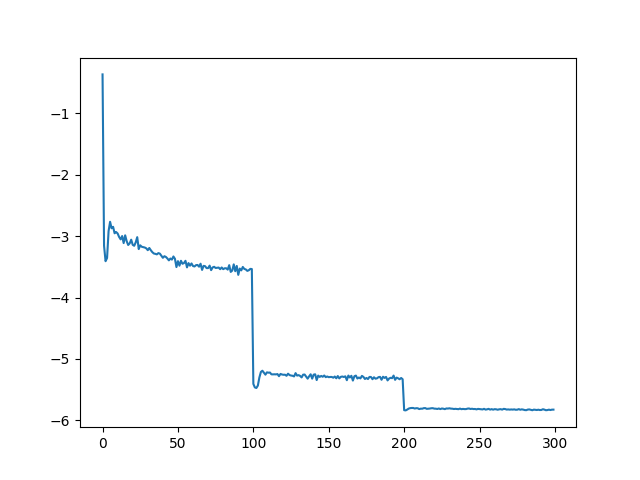

In [1583]:
plt.figure()
plt.plot(np.log(loss_x0_lin.history["loss"])/np.log(10))
plt.show()

In [1497]:
isolate = 1
X = np.array([all_X[i] for i in range(isolate)]+[all_X[i] for i in range(isolate+1,10)]).T
Y = all_X[isolate].T

In [1498]:
get_all_NN(all_X)


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0390
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.1673e-04
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.6388e-04
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.9796e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1945e-04
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.3411e-05
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.9633e-05
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.4672e-05
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4831e-05
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2470e-05
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.2293e-05
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.5067e-05
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.7297e-05
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/s

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2422e-05
Epoch 28/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2439e-05
Epoch 29/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6965e-05
Epoch 30/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.8777e-05
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6492e-05
Epoch 32/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3626e-05
Epoch 33/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0797e-05
Epoch 34/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4926e-05
Epoch 35/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5919e-05
Epoch 36/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5090e-05
Epoch 37/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4692e-05
Epoch 38/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6054e-05
Epoch 39/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7098e-05
Epoch 40/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0120
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0062
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0039
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0031
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0029
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0021
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0022
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0022
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0017
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023
Epoch 15/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0015
Epoch 16/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0016
Epoch 17/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0015
Epoch 18/50
1000/1000 ━━━━━━━━━━━━━━━

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1888e-05 - learning_rate: 0.0025
Epoch 25/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8242e-05 - learning_rate: 0.0025
Epoch 26/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7890e-05 - learning_rate: 0.0025
Epoch 27/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0737e-05 - learning_rate: 0.0025
Epoch 28/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9952e-05 - learning_rate: 0.0025
Epoch 29/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9941e-05 - learning_rate: 0.0025
Epoch 30/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7986e-05 - learning_rate: 0.0025
Epoch 31/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3728e-05 - learning_rate: 0.0025
Epoch 32/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4056e-05 - learning_rate: 0.0025
Epoch 33/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5704e-06 - learning_rate: 0.0012
Epoch 34/100
1000/1000 

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0767e-06 - learning_rate: 3.9062e-05
Epoch 85/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0832e-06 - learning_rate: 3.9062e-05
Epoch 86/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0286e-06 - learning_rate: 3.9062e-05
Epoch 87/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0335e-06 - learning_rate: 3.9062e-05
Epoch 88/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0763e-06 - learning_rate: 3.9062e-05
Epoch 89/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0482e-06 - learning_rate: 3.9062e-05
Epoch 90/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0943e-06 - learning_rate: 3.9062e-05
Epoch 91/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0265e-06 - learning_rate: 3.9062e-05
Epoch 92/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0391e-06 - learning_rate: 3.9062e-05
Epoch 93/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0246e-06 - learning_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2877e-06 - learning_rate: 6.2500e-04
Epoch 46/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.9047e-06 - learning_rate: 6.2500e-04
Epoch 47/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.4690e-06 - learning_rate: 6.2500e-04
Epoch 48/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.9664e-06 - learning_rate: 6.2500e-04
Epoch 49/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2822e-06 - learning_rate: 6.2500e-04
Epoch 50/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.7803e-06 - learning_rate: 6.2500e-04
Epoch 51/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.0474e-06 - learning_rate: 6.2500e-04
Epoch 52/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.1277e-06 - learning_rate: 6.2500e-04
Epoch 53/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.2644e-06 - learning_rate: 6.2500e-04
Epoch 54/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.9990e-06 - learning_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.0210e-04
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7667e-04
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5570e-04
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3255e-04
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3700e-04
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6663e-04
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2500e-04
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3225e-04
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2340e-04
Epoch 15/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1389e-04
Epoch 16/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0889e-04
Epoch 17/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1303e-04
Epoch 18/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1918e-04
Epoch 19/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/ste

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.9147e-05
Epoch 33/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.8239e-05
Epoch 34/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2274e-05
Epoch 35/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.2918e-05
Epoch 36/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.9202e-05
Epoch 37/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.9025e-05
Epoch 38/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.8998e-05
Epoch 39/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.3714e-05
Epoch 40/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.6336e-05
Epoch 41/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4183e-05
Epoch 42/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.5504e-05
Epoch 43/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5080e-05
Epoch 44/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.8324e-05
Epoch 45/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0199
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0175
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0163
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0133
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0168
Epoch 15/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0111
Epoch 16/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0111
Epoch 17/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0062
Epoch 18/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070
Epoch 19/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069
Epoch 20/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0058
Epoch 21/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0056
Epoch 22/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082
Epoch 23/50
1000/1000 ━━━━━━━━━━

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8167e-05 - learning_rate: 0.0025
Epoch 30/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2979e-05 - learning_rate: 0.0025
Epoch 31/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8654e-05 - learning_rate: 0.0025
Epoch 32/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.4402e-05 - learning_rate: 0.0025
Epoch 33/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.6557e-06 - learning_rate: 0.0012
Epoch 34/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3458e-05 - learning_rate: 0.0012
Epoch 35/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4176e-05 - learning_rate: 0.0012
Epoch 36/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8200e-05 - learning_rate: 0.0012
Epoch 37/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7180e-05 - learning_rate: 0.0012
Epoch 38/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4259e-05 - learning_rate: 0.0012
Epoch 39/100
1000/1000 

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.3603e-06 - learning_rate: 3.9062e-05
Epoch 90/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.1684e-06 - learning_rate: 3.9062e-05
Epoch 91/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1430e-06 - learning_rate: 3.9062e-05
Epoch 92/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.0917e-06 - learning_rate: 3.9062e-05
Epoch 93/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9201e-06 - learning_rate: 1.9531e-05
Epoch 94/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9945e-06 - learning_rate: 1.9531e-05
Epoch 95/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1024e-06 - learning_rate: 1.9531e-05
Epoch 96/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9226e-06 - learning_rate: 1.9531e-05
Epoch 97/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2244e-06 - learning_rate: 1.9531e-05
Epoch 98/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9893e-06 - learning_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.7372e-05
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.1792e-05
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2341e-05
Epoch 15/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3338e-05
Epoch 16/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.4203e-05
Epoch 17/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.5907e-05
Epoch 18/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.1134e-05
Epoch 19/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0894e-05
Epoch 20/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0997e-05
Epoch 21/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.8698e-05
Epoch 22/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1639e-05
Epoch 23/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.8106e-05
Epoch 24/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.3228e-05
Epoch 25/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.7266e-05
Epoch 39/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.3499e-05
Epoch 40/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.7406e-05
Epoch 41/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1599e-05
Epoch 42/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.3389e-05
Epoch 43/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1480e-05
Epoch 44/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.9523e-05
Epoch 45/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.9020e-05
Epoch 46/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.4060e-05
Epoch 47/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7846e-05
Epoch 48/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9333e-05
Epoch 49/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7460e-05
Epoch 50/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1681e-05
Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/s

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1721e-04 - learning_rate: 0.0100
Epoch 12/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.8256e-04 - learning_rate: 0.0100
Epoch 13/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5075e-05 - learning_rate: 0.0050
Epoch 14/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6356e-05 - learning_rate: 0.0050
Epoch 15/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.3243e-05 - learning_rate: 0.0050
Epoch 16/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8893e-05 - learning_rate: 0.0050
Epoch 17/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.6111e-05 - learning_rate: 0.0050
Epoch 18/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1732e-05 - learning_rate: 0.0050
Epoch 19/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9905e-05 - learning_rate: 0.0050
Epoch 20/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.1478e-05 - learning_rate: 0.0050
Epoch 21/100
1000/1000 

Epoch 72/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.7808e-07 - learning_rate: 1.5625e-04
Epoch 73/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.8829e-07 - learning_rate: 7.8125e-05
Epoch 74/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.2658e-07 - learning_rate: 7.8125e-05
Epoch 75/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.1846e-07 - learning_rate: 7.8125e-05
Epoch 76/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.8617e-07 - learning_rate: 7.8125e-05
Epoch 77/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.9536e-07 - learning_rate: 7.8125e-05
Epoch 78/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.1882e-07 - learning_rate: 7.8125e-05
Epoch 79/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.8892e-07 - learning_rate: 7.8125e-05
Epoch 80/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.9193e-07 - learning_rate: 7.8125e-05
Epoch 81/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.8818e-0

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1319e-05 - learning_rate: 0.0025
Epoch 33/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4231e-05 - learning_rate: 0.0025
Epoch 34/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.4481e-05 - learning_rate: 0.0025
Epoch 35/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.5558e-06 - learning_rate: 0.0012
Epoch 36/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.6266e-06 - learning_rate: 0.0012
Epoch 37/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.8632e-06 - learning_rate: 0.0012
Epoch 38/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0546e-05 - learning_rate: 0.0012
Epoch 39/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.3459e-06 - learning_rate: 0.0012
Epoch 40/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.6390e-06 - learning_rate: 0.0012
Epoch 41/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2295e-05 - learning_rate: 0.0012
Epoch 42/100
1000/1000 

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.8088e-07 - learning_rate: 3.9062e-05
Epoch 93/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.4077e-07 - learning_rate: 3.9062e-05
Epoch 94/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.6612e-07 - learning_rate: 3.9062e-05
Epoch 95/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2094e-07 - learning_rate: 1.9531e-05
Epoch 96/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.4019e-07 - learning_rate: 1.9531e-05
Epoch 97/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.8018e-07 - learning_rate: 1.9531e-05
Epoch 98/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2005e-07 - learning_rate: 1.9531e-05
Epoch 99/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.6046e-07 - learning_rate: 1.9531e-05
Epoch 100/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.0568e-07 - learning_rate: 1.9531e-05
Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0438
Epoch 2/50
1000/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3864e-05
Epoch 16/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.6867e-05
Epoch 17/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.0976e-05
Epoch 18/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.5035e-05
Epoch 19/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.7783e-05
Epoch 20/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.8504e-05
Epoch 21/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2661e-05
Epoch 22/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1657e-05
Epoch 23/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.6643e-05
Epoch 24/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.2627e-05
Epoch 25/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.8238e-05
Epoch 26/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4378e-05
Epoch 27/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2191e-05
Epoch 28/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1085e-05
Epoch 42/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2670e-05
Epoch 43/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.8099e-05
Epoch 44/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4995e-04
Epoch 45/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2804e-05
Epoch 46/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1983e-05
Epoch 47/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.0403e-05
Epoch 48/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.6655e-05
Epoch 49/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.5178e-05
Epoch 50/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1514e-05
Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1980
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1433
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0392
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1299e-05 - learning_rate: 0.0050
Epoch 15/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1379e-05 - learning_rate: 0.0050
Epoch 16/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1345e-05 - learning_rate: 0.0050
Epoch 17/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2659e-05 - learning_rate: 0.0050
Epoch 18/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.7347e-05 - learning_rate: 0.0050
Epoch 19/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9891e-05 - learning_rate: 0.0050
Epoch 20/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.7026e-05 - learning_rate: 0.0050
Epoch 21/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8789e-05 - learning_rate: 0.0050
Epoch 22/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9139e-05 - learning_rate: 0.0050
Epoch 23/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.5645e-06 - learning_rate: 0.0025
Epoch 24/100
1000/1000 

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1845e-06 - learning_rate: 7.8125e-05
Epoch 75/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2330e-06 - learning_rate: 7.8125e-05
Epoch 76/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2318e-06 - learning_rate: 7.8125e-05
Epoch 77/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2128e-06 - learning_rate: 7.8125e-05
Epoch 78/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2115e-06 - learning_rate: 7.8125e-05
Epoch 79/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2218e-06 - learning_rate: 7.8125e-05
Epoch 80/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1942e-06 - learning_rate: 7.8125e-05
Epoch 81/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2506e-06 - learning_rate: 7.8125e-05
Epoch 82/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2132e-06 - learning_rate: 7.8125e-05
Epoch 83/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1500e-06 - learning_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8277e-05
Epoch 43/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4203e-05
Epoch 44/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4400e-05
Epoch 45/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3158e-05
Epoch 46/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3140e-05
Epoch 47/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2031e-05
Epoch 48/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.7329e-06
Epoch 49/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2593e-05
Epoch 50/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0818e-05
Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0027
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.3847e-05
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.8965e-05
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1094e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lo

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.9613e-05
Epoch 19/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.9458e-05
Epoch 20/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0863e-05
Epoch 21/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5946e-05
Epoch 22/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.2098e-05
Epoch 23/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.2871e-05
Epoch 24/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.8409e-05
Epoch 25/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.6633e-05
Epoch 26/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.9304e-05
Epoch 27/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.0909e-05
Epoch 28/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.1035e-05
Epoch 29/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9715e-05
Epoch 30/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4509e-05
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2752e-06
Epoch 45/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.0854e-06
Epoch 46/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5482e-06
Epoch 47/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.8645e-06
Epoch 48/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5883e-06
Epoch 49/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.3489e-06
Epoch 50/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.0266e-06
For x4, the orders to analyse are [4, 3].
For x4, analysing 4.
Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6898 - learning_rate: 0.0100
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.6339e-07 - learning_rate: 0.0100
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0782e-07 - learning_rate: 0.0100
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.3617e-07 - learning_rate: 0.0100
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.1113e-08 - learning_rate: 3.1250e-04
Epoch 57/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1288e-07 - learning_rate: 3.1250e-04
Epoch 58/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0690e-07 - learning_rate: 3.1250e-04
Epoch 59/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0171e-07 - learning_rate: 3.1250e-04
Epoch 60/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0824e-07 - learning_rate: 3.1250e-04
Epoch 61/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1022e-07 - learning_rate: 3.1250e-04
Epoch 62/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1355e-07 - learning_rate: 3.1250e-04
Epoch 63/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2429e-08 - learning_rate: 1.5625e-04
Epoch 64/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6099e-08 - learning_rate: 1.5625e-04
Epoch 65/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8281e-08 - learning_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9715e-05 - learning_rate: 0.0050
Epoch 17/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2894e-05 - learning_rate: 0.0050
Epoch 18/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2049e-05 - learning_rate: 0.0050
Epoch 19/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7418e-05 - learning_rate: 0.0050
Epoch 20/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0500e-05 - learning_rate: 0.0050
Epoch 21/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1047e-05 - learning_rate: 0.0050
Epoch 22/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7276e-05 - learning_rate: 0.0050
Epoch 23/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8704e-06 - learning_rate: 0.0025
Epoch 24/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1463e-06 - learning_rate: 0.0025
Epoch 25/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.3079e-06 - learning_rate: 0.0025
Epoch 26/100
1000/1000 

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6417e-08 - learning_rate: 7.8125e-05
Epoch 77/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9798e-08 - learning_rate: 7.8125e-05
Epoch 78/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5769e-08 - learning_rate: 7.8125e-05
Epoch 79/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7400e-08 - learning_rate: 7.8125e-05
Epoch 80/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6202e-08 - learning_rate: 7.8125e-05
Epoch 81/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7481e-08 - learning_rate: 7.8125e-05
Epoch 82/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7634e-08 - learning_rate: 7.8125e-05
Epoch 83/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8385e-08 - learning_rate: 3.9062e-05
Epoch 84/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.6918e-08 - learning_rate: 3.9062e-05
Epoch 85/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9964e-08 - learning_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8383e-05
Epoch 46/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2064e-05
Epoch 47/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.6967e-05
Epoch 48/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.4095e-05
Epoch 49/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.0842e-05
Epoch 50/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3941e-05
Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3596
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0663
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0099
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0037
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0015
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.3147e-04
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.6538e-04
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1671e-04
Epoc

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5196e-04
Epoch 22/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.0748e-04
Epoch 23/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.1394e-04
Epoch 24/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.5091e-04
Epoch 25/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.5590e-04
Epoch 26/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.6235e-04
Epoch 27/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4989e-04
Epoch 28/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4443e-04
Epoch 29/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.3158e-04
Epoch 30/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.4846e-04
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.8989e-04
Epoch 32/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.9571e-04
Epoch 33/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.7498e-04
Epoch 34/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0027
Epoch 49/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0049
Epoch 50/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0016
For x5, the orders to analyse are [0].
For x5, analysing 0.
Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7386 - learning_rate: 0.0100
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9405e-04 - learning_rate: 0.0100
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5283e-04 - learning_rate: 0.0100
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2839e-04 - learning_rate: 0.0100
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9073e-04 - learning_rate: 0.0100
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.4667e-04 - learning_rate: 0.0100
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6584e-04 - learning_rate: 0.0100
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - los

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.4690e-06 - learning_rate: 3.1250e-04
Epoch 60/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3707e-06 - learning_rate: 3.1250e-04
Epoch 61/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1250e-06 - learning_rate: 3.1250e-04
Epoch 62/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2253e-06 - learning_rate: 3.1250e-04
Epoch 63/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6885e-06 - learning_rate: 1.5625e-04
Epoch 64/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7559e-06 - learning_rate: 1.5625e-04
Epoch 65/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6997e-06 - learning_rate: 1.5625e-04
Epoch 66/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7961e-06 - learning_rate: 1.5625e-04
Epoch 67/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7400e-06 - learning_rate: 1.5625e-04
Epoch 68/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8133e-06 - learning_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6347e-05
Epoch 24/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0333e-05
Epoch 25/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7893e-05
Epoch 26/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6641e-05
Epoch 27/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8636e-05
Epoch 28/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8885e-05
Epoch 29/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6727e-05
Epoch 30/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6513e-05
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7794e-05
Epoch 32/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7524e-05
Epoch 33/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6411e-05
Epoch 34/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5755e-05
Epoch 35/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0552e-05
Epoch 36/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6077e-05
Epoch 50/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4609e-05
Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0365
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0123
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0036
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0017
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0011
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.4154e-04
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.9575e-04
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.4328e-04
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2748e-04
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.9642e-04
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.7040e-04
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.3147e-04
Epoch

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1791e-04
Epoch 26/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2504e-04
Epoch 27/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9372e-04
Epoch 28/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.2070e-04
Epoch 29/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1768e-04
Epoch 30/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7855e-04
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1210e-04
Epoch 32/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6587e-04
Epoch 33/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8314e-04
Epoch 34/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8757e-04
Epoch 35/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6061e-04
Epoch 36/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6436e-04
Epoch 37/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2444e-04
Epoch 38/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8210e-06 - learning_rate: 0.0012
Epoch 42/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.3508e-06 - learning_rate: 0.0012
Epoch 43/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9253e-06 - learning_rate: 6.2500e-04
Epoch 44/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2866e-06 - learning_rate: 6.2500e-04
Epoch 45/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6630e-06 - learning_rate: 6.2500e-04
Epoch 46/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5786e-06 - learning_rate: 6.2500e-04
Epoch 47/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9842e-06 - learning_rate: 6.2500e-04
Epoch 48/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6687e-06 - learning_rate: 6.2500e-04
Epoch 49/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5414e-06 - learning_rate: 6.2500e-04
Epoch 50/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7394e-06 - learning_rate: 6.

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0262
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.6506e-05
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0323e-04
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0563e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.5093e-05
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.7499e-05
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.5488e-05
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.7494e-05
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.0185e-05
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.2504e-05
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.9339e-05
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7144e-05
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.4958e-05
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/s

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.6979e-05
Epoch 28/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4087e-05
Epoch 29/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1653e-05
Epoch 30/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.0626e-05
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.8141e-05
Epoch 32/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3464e-05
Epoch 33/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7792e-05
Epoch 34/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.6310e-05
Epoch 35/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.5393e-05
Epoch 36/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.4736e-05
Epoch 37/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6360e-05
Epoch 38/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3914e-05
Epoch 39/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9609e-05
Epoch 40/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0120
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0044
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0027
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0022
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0031
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0020
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0022
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.2571e-04
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.3638e-04
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.4204e-04
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.3055e-04
Epoch 15/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.6444e-04
Epoch 16/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.0306e-04
Epoch 17/50
10

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.3521e-06 - learning_rate: 0.0025
Epoch 24/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.1908e-06 - learning_rate: 0.0025
Epoch 25/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3433e-05 - learning_rate: 0.0025
Epoch 26/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5116e-05 - learning_rate: 0.0025
Epoch 27/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0735e-05 - learning_rate: 0.0025
Epoch 28/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6315e-05 - learning_rate: 0.0025
Epoch 29/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1564e-05 - learning_rate: 0.0025
Epoch 30/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4352e-05 - learning_rate: 0.0025
Epoch 31/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5467e-05 - learning_rate: 0.0025
Epoch 32/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2197e-05 - learning_rate: 0.0025
Epoch 33/100
1000/1000 

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3689e-06 - learning_rate: 3.9062e-05
Epoch 84/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3967e-06 - learning_rate: 3.9062e-05
Epoch 85/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3947e-06 - learning_rate: 3.9062e-05
Epoch 86/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3527e-06 - learning_rate: 3.9062e-05
Epoch 87/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3633e-06 - learning_rate: 3.9062e-05
Epoch 88/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3771e-06 - learning_rate: 3.9062e-05
Epoch 89/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3330e-06 - learning_rate: 3.9062e-05
Epoch 90/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4037e-06 - learning_rate: 3.9062e-05
Epoch 91/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3592e-06 - learning_rate: 3.9062e-05
Epoch 92/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3802e-06 - learning_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.9135e-06 - learning_rate: 6.2500e-04
Epoch 45/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2180e-06 - learning_rate: 6.2500e-04
Epoch 46/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.9860e-06 - learning_rate: 6.2500e-04
Epoch 47/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.3414e-06 - learning_rate: 6.2500e-04
Epoch 48/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.3318e-06 - learning_rate: 6.2500e-04
Epoch 49/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8747e-06 - learning_rate: 6.2500e-04
Epoch 50/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2941e-06 - learning_rate: 6.2500e-04
Epoch 51/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.8242e-06 - learning_rate: 6.2500e-04
Epoch 52/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.1325e-06 - learning_rate: 6.2500e-04
Epoch 53/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.0417e-06 - learning_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2862e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1380e-04
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0837e-04
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.4729e-05
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0463e-04
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.1527e-05
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.6902e-05
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.9223e-05
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.1196e-05
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.3067e-05
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.8513e-05
Epoch 15/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.9530e-05
Epoch 16/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.6679e-05
Epoch 17/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step 

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.7723e-05
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.6141e-05
Epoch 32/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.8496e-05
Epoch 33/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2775e-05
Epoch 34/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5217e-05
Epoch 35/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.7612e-05
Epoch 36/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.7555e-05
Epoch 37/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.6966e-05
Epoch 38/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.9034e-05
Epoch 39/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.2329e-05
Epoch 40/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.6452e-05
Epoch 41/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4265e-05
Epoch 42/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.4740e-05
Epoch 43/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0642
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0330
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0177
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0506
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0243
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0183
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0212
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0202
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0045
Epoch 15/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093
Epoch 16/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096
Epoch 17/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0056
Epoch 18/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089
Epoch 19/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0063
Epoch 20/50
1000/1000 ━━━━━━━━━━━━━

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5752e-05 - learning_rate: 0.0025
Epoch 28/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8062e-05 - learning_rate: 0.0025
Epoch 29/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3949e-05 - learning_rate: 0.0025
Epoch 30/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1218e-05 - learning_rate: 0.0025
Epoch 31/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.3041e-05 - learning_rate: 0.0025
Epoch 32/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.3242e-05 - learning_rate: 0.0025
Epoch 33/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.0974e-06 - learning_rate: 0.0012
Epoch 34/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.8893e-06 - learning_rate: 0.0012
Epoch 35/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0332e-05 - learning_rate: 0.0012
Epoch 36/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2640e-06 - learning_rate: 0.0012
Epoch 37/100
1000/1000 

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1899e-06 - learning_rate: 3.9062e-05
Epoch 88/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2631e-06 - learning_rate: 3.9062e-05
Epoch 89/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2376e-06 - learning_rate: 3.9062e-05
Epoch 90/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2498e-06 - learning_rate: 3.9062e-05
Epoch 91/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2262e-06 - learning_rate: 3.9062e-05
Epoch 92/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2063e-06 - learning_rate: 3.9062e-05
Epoch 93/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1577e-06 - learning_rate: 1.9531e-05
Epoch 94/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1573e-06 - learning_rate: 1.9531e-05
Epoch 95/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.1182e-06 - learning_rate: 1.9531e-05
Epoch 96/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1594e-06 - learning_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3853e-04
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.2147e-04
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5808e-04
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4519e-04
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1726e-04
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7649e-04
Epoch 15/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6616e-04
Epoch 16/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4666e-04
Epoch 17/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3703e-04
Epoch 18/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3073e-04
Epoch 19/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3052e-04
Epoch 20/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3146e-04
Epoch 21/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4436e-04
Epoch 22/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.5520e-04
Epoch 37/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.6985e-04
Epoch 38/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.4943e-04
Epoch 39/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0011
Epoch 40/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.2110e-04
Epoch 41/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.5992e-04
Epoch 42/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.7945e-04
Epoch 43/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0013
Epoch 44/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.9194e-04
Epoch 45/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0012
Epoch 46/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.7652e-04
Epoch 47/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0016
Epoch 48/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.7752e-04
Epoch 49/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.3

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8668e-05 - learning_rate: 0.0100
Epoch 12/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.0546e-04 - learning_rate: 0.0100
Epoch 13/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4204e-05 - learning_rate: 0.0050
Epoch 14/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.8495e-05 - learning_rate: 0.0050
Epoch 15/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1901e-04 - learning_rate: 0.0050
Epoch 16/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5264e-04 - learning_rate: 0.0050
Epoch 17/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2068e-05 - learning_rate: 0.0050
Epoch 18/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8998e-04 - learning_rate: 0.0050
Epoch 19/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2351e-04 - learning_rate: 0.0050
Epoch 20/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0635e-05 - learning_rate: 0.0050
Epoch 21/100
1000/1000 

Epoch 72/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9709e-06 - learning_rate: 1.5625e-04
Epoch 73/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6898e-06 - learning_rate: 7.8125e-05
Epoch 74/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7120e-06 - learning_rate: 7.8125e-05
Epoch 75/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6885e-06 - learning_rate: 7.8125e-05
Epoch 76/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7574e-06 - learning_rate: 7.8125e-05
Epoch 77/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7048e-06 - learning_rate: 7.8125e-05
Epoch 78/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6291e-06 - learning_rate: 7.8125e-05
Epoch 79/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7200e-06 - learning_rate: 7.8125e-05
Epoch 80/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6594e-06 - learning_rate: 7.8125e-05
Epoch 81/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6579e-0

In [ ]:
####

In [1500]:
X = np.array([all_X[i] for i in range(4)]+[all_X[i] for i in range(4+1,10)]).T
Y = all_X[4].T

In [1502]:
best_losses = find_order(X, Y, max_order = 4 ,n_epochs = 50)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0131
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3912e-05
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8563e-05
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6534e-05
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.9255e-05
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.4963e-05
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.0195e-05
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.4544e-05
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.4780e-05
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2810e-05
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.4717e-05
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1811e-05
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.4370e-05
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/s

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7535e-05
Epoch 28/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4071e-05
Epoch 29/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5022e-05
Epoch 30/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5481e-05
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5620e-05
Epoch 32/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6358e-05
Epoch 33/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2482e-05
Epoch 34/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2482e-05
Epoch 35/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2225e-05
Epoch 36/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1445e-05
Epoch 37/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0034e-05
Epoch 38/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.8124e-06
Epoch 39/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1453e-05
Epoch 40/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.6974e-07
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1620e-06
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.3973e-05
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.8985e-05
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.4358e-05
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.9994e-05
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0796e-05
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5563e-05
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.3034e-05
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.7250e-05
Epoch 13/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.7854e-05
Epoch 14/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.6460e-05
Epoch 15/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.7565e-05
Epoch 16/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

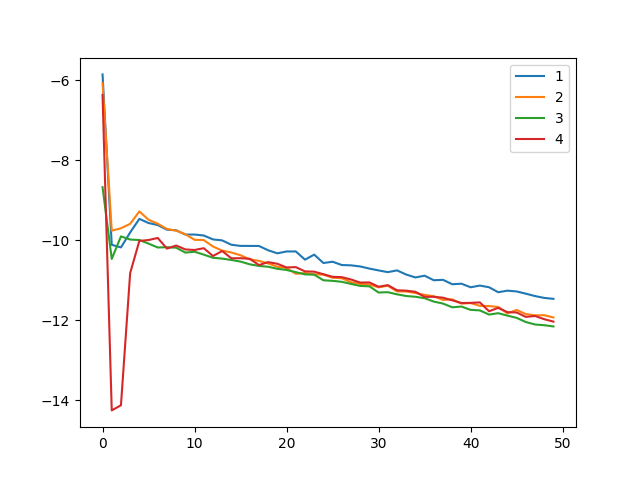

In [1503]:
plt.figure()
for i in best_losses:
    plt.plot(np.log(i[1]),label=i[0])
plt.legend()
plt.show()

In [1470]:
select_order(best_losses, tol = 10**(-2))


[0, 1]

In [1539]:
model_x1_squared,loss_x1_squared = learn_one_x_from_the_others(X, Y, order=2, n_epochs = 100)


Epoch 1/100


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(100,), dtype=float32). Expected shape (None, 9), but input has incompatible shape (100,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(100,), dtype=float32)
  • training=True
  • mask=None

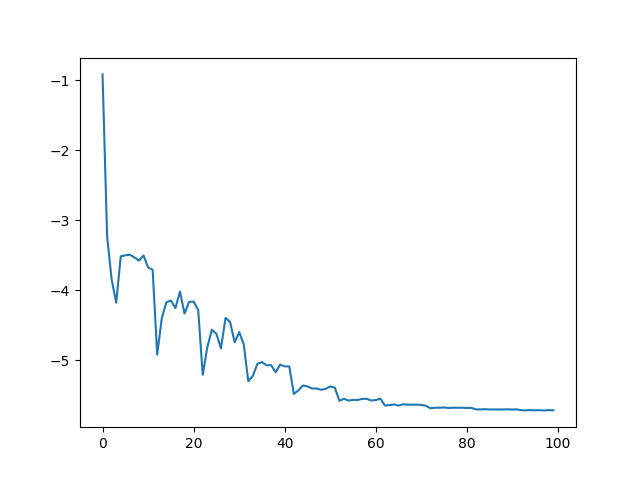

In [1450]:
plt.figure()
plt.plot(np.log(loss_x1_squared.history["loss"])/np.log(10))
plt.show()

In [1584]:
save_nn(model_x0_lin,"10d_x1_lin")
